# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [ ]:
# Import warnings

import warnings; warnings.simplefilter('ignore')

In [ ]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


In [ ]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:
# Try loading one file

# df = pd.read_parquet('2023-1.parquet')
# df.info()
from google.colab import files
uploaded = files.upload()

Saving 2023-5.parquet to 2023-5.parquet


In [ ]:
df= pd.read_parquet('2023-1.parquet')


How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
combined_sampled_data1=pd.DataFrame()

In [ ]:
# Take a small percentage of entries from each hour of every date.

# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
#os.chdir('/content/Assignments/EDA/data_NYC_Taxi/trip_records')

# Create a list of all the twelve files to read
#file_list = os.listdir()

# initialise an empty dataframe
#df = pd.DataFrame()


# iterate through the list of files and sample one by one:
#for file_name in file_list:
 #   try:
        # file path for the current file
  #      file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
df= pd.read_parquet('2023-1.parquet')


        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.

        # Loop through dates and then loop through every hour of each date

            # Iterate through each hour of the selected date


                # add data of this hour to the dataframe
              df['pickup_date'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.date
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
sampled_data = pd.DataFrame()
for date in df['pickup_date'].unique():
    for hour in range(24):
        # Filter data for the specific date and hour
        hour_data = df[(df['pickup_date'] == date) & (df['pickup_hour'] == hour)]

        if not hour_data.empty:
            # Sample 1% of that hour's data
            sample = hour_data.sample(frac=0.01, random_state=42)
            sampled_data = pd.concat([sampled_data, sample], ignore_index=True)

        # Concatenate the sampled data of all the dates to a single dataframe
        sampled_data.shape
        combined_sampled_data1 = pd.concat([combined_sampled_data1, sampled_data], ignore_index=True)
    #except Exception as e:
     #   print(f"Error reading file {file_name}: {e}")

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
# Store the df in csv/parquet
# df.to_parquet('')

In [ ]:
combined_sampled_data1.to_csv("combined_sampled_data1.csv", mode='a', header=False, index=False)
from google.colab import files
files.download('combined_sampled_data1.csv')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving combined_sampled_data (3).xlsx to combined_sampled_data (3).xlsx


## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [ ]:
# Load the new data file

df= pd.read_excel("combined_sampled_data (3).xlsx")

In [ ]:
# df.head()
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
4          19.24         NaN                NaN            66           107   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             2  ...      0.5        0.00           0.0   
1             1  ...      0.5        2.58           0.0   
2             2  ...      0.5        0.00           0.0   
3             2  ...      0.5        0.00           0.0   
4             0  ...      0.5        5.93           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.15                   0.0         1.25   
1                    1.0         15.48                   2.5         0.00   
2                    1.0         16.40                   2.5         0.00   
3                    1.0         11.50                   2.5         0.00   
4                    1.0         35.57                   NaN          NaN   

   pickup_date  pickup_hour Airport_fee  
0   2023-01-01            0         NaN  
1   2023-01-01            0         NaN  
2   2023-01-01            0         NaN  
3   2023-01-01            0         NaN  
4   2023-01-01            0         NaN  

[5 rows x 22 columns]

In [ ]:
# df.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1048575 non-null  int64         
 1   tpep_pickup_datetime   1048575 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1048575 non-null  datetime64[ns]
 3   passenger_count        1021402 non-null  float64       
 4   trip_distance          1048575 non-null  float64       
 5   RatecodeID             1021402 non-null  float64       
 6   store_and_fwd_flag     1021402 non-null  object        
 7   PULocationID           1048575 non-null  int64         
 8   DOLocationID           1048575 non-null  int64         
 9   payment_type           1048575 non-null  int64         
 10  fare_amount            1048575 non-null  float64       
 11  extra                  1048575 non-null  float64       
 12  mta_tax                10485

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [ ]:
df1=df

In [ ]:
# Fix the index and drop any columns that are not needed

df.reset_index(drop=True, inplace=True)



In [ ]:
df.shape

(1048575, 22)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [ ]:
# Combine the two airport fee columns
df['airport_fee_combined'] = df['Airport_fee'].combine_first(df['airport_fee'])

# Drop the old inconsistent columns
df.drop(columns=['airport_fee', 'Airport_fee'], inplace=True, errors='ignore')

# Optionally rename the combined column to just 'airport_fee'
df.rename(columns={'airport_fee_combined': 'airport_fee'}, inplace=True)


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1048575 non-null  int64         
 1   tpep_pickup_datetime   1048575 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1048575 non-null  datetime64[ns]
 3   passenger_count        1021402 non-null  float64       
 4   trip_distance          1048575 non-null  float64       
 5   RatecodeID             1021402 non-null  float64       
 6   store_and_fwd_flag     1021402 non-null  object        
 7   PULocationID           1048575 non-null  int64         
 8   DOLocationID           1048575 non-null  int64         
 9   payment_type           1048575 non-null  int64         
 10  fare_amount            1048575 non-null  float64       
 11  extra                  1048575 non-null  float64       
 12  mta_tax                10485

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [ ]:
# check where values of fare amount are negative

(df['fare_amount']<0).sum()

np.int64(0)

Did you notice something different in the `RatecodeID` column for above records?

In [ ]:
# Analyse RatecodeID for the negative fare amounts
df['RatecodeID'].value_counts()


RatecodeID
1.0     967180
2.0      39254
99.0      5230
5.0       4878
3.0       3250
4.0       1608
6.0          2
Name: count, dtype: int64

In [ ]:
# Find which columns have negative values
negative_columns = df.select_dtypes(include=['number']).columns[(df.select_dtypes(include=['number']) < 0).any()]
negative_columns.to_list()

['mta_tax',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

In [ ]:
# fix these negative values

# Select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Replace negative values with 0 in numeric columns
df[numeric_cols] = df[numeric_cols].applymap(lambda x: 0 if x < 0 else x)

In [ ]:
df.shape

(1048575, 21)

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [ ]:
# Find the proportion of missing values in each column
missing_proportions = df.isnull().mean()
missing_proportions_percent = missing_proportions * 100
missing_proportions_percent



VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          2.591422
trip_distance            0.000000
RatecodeID               2.591422
store_and_fwd_flag       2.591422
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     2.591422
pickup_date              0.000000
pickup_hour              0.000000
airport_fee              2.591422
dtype: float64

In [ ]:
missing_proportions_percent

VendorID                  0.000000
tpep_pickup_datetime      0.000000
tpep_dropoff_datetime     0.000000
passenger_count           2.648555
trip_distance             0.000000
RatecodeID                2.648555
store_and_fwd_flag        2.648555
PULocationID              0.000000
DOLocationID              0.000000
payment_type              0.000000
fare_amount               0.000000
extra                     0.000000
mta_tax                   0.000000
tip_amount                0.000000
tolls_amount              0.000000
improvement_surcharge     0.000000
total_amount              0.000000
congestion_surcharge      2.648555
Airport_fee              33.276220
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [ ]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
df[df['passenger_count'].isnull()]
df = df.dropna(subset=['passenger_count'])

In [ ]:
df['passenger_count'].value_counts()

passenger_count
1.0    774743
2.0    149954
3.0     36771
4.0     18398
5.0     14387
6.0      9167
8.0         2
9.0         1
Name: count, dtype: int64

*Did* you find zeroes in passenger_count? Handle these.

In [ ]:
df = df[df['passenger_count'] != 0]


In [ ]:
df.shape

(1003423, 21)

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [ ]:
# Fix missing values in 'RatecodeID'
df['RatecodeID'].value_counts()
df[df['RatecodeID'].isnull()]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, pickup_date, pickup_hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [ ]:
# handle null values in congestion_surcharge
df['congestion_surcharge'].value_counts()

congestion_surcharge
2.5    927194
0.0     76229
Name: count, dtype: int64

In [ ]:
# Handle any remaining missing values
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 1003423 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1003423 non-null  int64         
 1   tpep_pickup_datetime   1003423 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1003423 non-null  datetime64[ns]
 3   passenger_count        1003423 non-null  float64       
 4   trip_distance          1003423 non-null  float64       
 5   RatecodeID             1003423 non-null  float64       
 6   store_and_fwd_flag     1003423 non-null  object        
 7   PULocationID           1003423 non-null  int64         
 8   DOLocationID           1003423 non-null  int64         
 9   payment_type           1003423 non-null  int64         
 10  fare_amount            1003423 non-null  float64       
 11  extra                  1003423 non-null  float64       
 12  mta_tax                1003423 no

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
pickup_date              0
pickup_hour              0
airport_fee              0
dtype: int64

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [ ]:
# handle null values in congestion_surcharge

df['congestion_surcharge'].isna().sum()


np.int64(0)

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [ ]:
# Handle any remaining missing values

df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 1003423 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1003423 non-null  int64         
 1   tpep_pickup_datetime   1003423 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1003423 non-null  datetime64[ns]
 3   passenger_count        1003423 non-null  float64       
 4   trip_distance          1003423 non-null  float64       
 5   RatecodeID             1003423 non-null  float64       
 6   store_and_fwd_flag     1003423 non-null  object        
 7   PULocationID           1003423 non-null  int64         
 8   DOLocationID           1003423 non-null  int64         
 9   payment_type           1003423 non-null  int64         
 10  fare_amount            1003423 non-null  float64       
 11  extra                  1003423 non-null  float64       
 12  mta_tax                1003423 no

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
pickup_date              0
pickup_hour              0
airport_fee              0
dtype: int64

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [ ]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
df.describe()


VendorID           tpep_pickup_datetime  \
count  1.003423e+06                        1003423   
mean   1.735320e+00  2023-03-13 02:20:09.682570496   
min    1.000000e+00            2022-12-31 23:51:30   
25%    1.000000e+00     2023-01-27 17:33:03.500000   
50%    2.000000e+00            2023-03-10 20:20:58   
75%    2.000000e+00     2023-03-25 19:50:35.500000   
max    2.000000e+00            2023-07-01 00:00:51   
std    4.411629e-01                            NaN   

               tpep_dropoff_datetime  passenger_count  trip_distance  \
count                        1003423     1.003423e+06   1.003423e+06   
mean   2023-03-13 02:36:43.940739072     1.380792e+00   3.501211e+00   
min              2022-12-31 23:56:06     1.000000e+00   0.000000e+00   
25%       2023-01-27 17:47:57.500000     1.000000e+00   1.060000e+00   
50%              2023-03-10 20:34:46     1.000000e+00   1.790000e+00   
75%       2023-03-25 20:06:21.500000     1.000000e+00   3.330000e+00   
max              2023-07-01 18:21:41     9.000000e+00   1.096143e+04   
std                              NaN     8.797737e-01   3.019205e+01   

         RatecodeID  PULocationID  DOLocationID  payment_type   fare_amount  \
count  1.003423e+06  1.003423e+06  1.003423e+06  1.003423e+06  1.003423e+06   
mean   1.578246e+00  1.658924e+02  1.643445e+02  1.202132e+00  1.912904e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    1.000000e+00  1.320000e+02  1.140000e+02  1.000000e+00  9.300000e+00   
50%    1.000000e+00  1.620000e+02  1.620000e+02  1.000000e+00  1.280000e+01   
75%    1.000000e+00  2.340000e+02  2.340000e+02  1.000000e+00  2.120000e+01   
max    9.900000e+01  2.650000e+02  2.650000e+02  4.000000e+00  9.990000e+02   
std    7.052663e+00  6.367597e+01  6.975198e+01  4.593937e-01  1.781627e+01   

              extra       mta_tax    tip_amount  tolls_amount  \
count  1.003423e+06  1.003423e+06  1.003423e+06  1.003423e+06   
mean   1.634135e+00  4.959216e-01  3.490040e+00  5.628003e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  5.000000e-01  1.000000e+00  0.000000e+00   
50%    1.000000e+00  5.000000e-01  2.800000e+00  0.000000e+00   
75%    2.500000e+00  5.000000e-01  4.300000e+00  0.000000e+00   
max    1.375000e+01  4.000000e+00  2.020000e+02  7.775000e+01   
std    1.813591e+00  4.556052e-02  3.939545e+00  2.089736e+00   

       improvement_surcharge  total_amount  congestion_surcharge  \
count           1.003423e+06  1.003423e+06          1.003423e+06   
mean            9.988788e-01  2.810536e+01          2.310078e+00   
min             0.000000e+00  0.000000e+00          0.000000e+00   
25%             1.000000e+00  1.570000e+01          2.500000e+00   
50%             1.000000e+00  2.052000e+01          2.500000e+00   
75%             1.000000e+00  2.970000e+01          2.500000e+00   
max             1.000000e+00  1.000000e+03          2.500000e+00   
std             3.065815e-02  2.224114e+01          6.623714e-01   

                         pickup_date   pickup_hour   airport_fee  
count                        1003423  1.003423e+06  1.003423e+06  
mean   2023-03-12 11:32:36.035291136  1.429146e+01  1.150011e-01  
min              2022-12-31 00:00:00  0.000000e+00  0.000000e+00  
25%              2023-01-27 00:00:00  1.100000e+01  0.000000e+00  
50%              2023-03-10 00:00:00  1.500000e+01  0.000000e+00  
75%              2023-03-25 00:00:00  1.900000e+01  0.000000e+00  
max              2023-07-01 00:00:00  2.300000e+01  1.750000e+00  
std                              NaN  5.767413e+00  3.778160e-01

In [ ]:
# Check for missing values
df.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
pickup_date              0
pickup_hour              0
airport_fee              0
dtype: int64

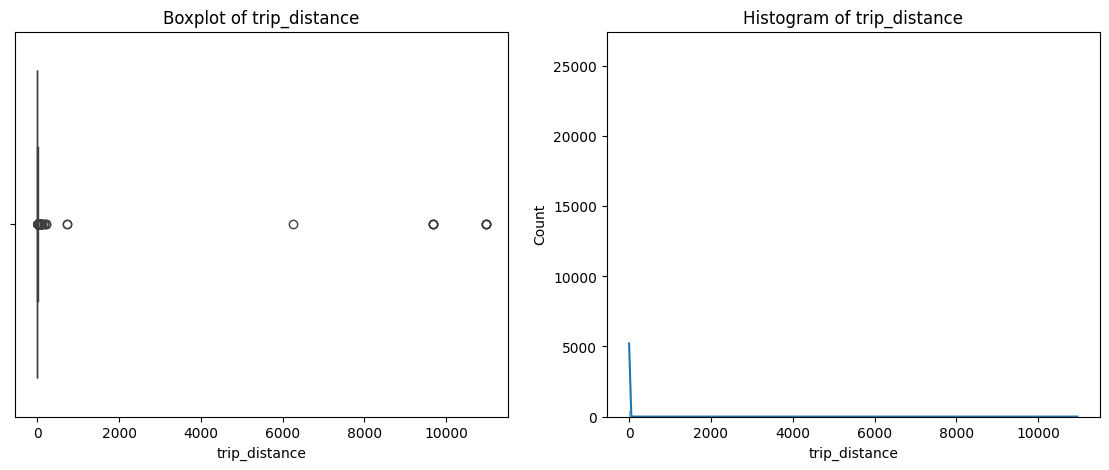

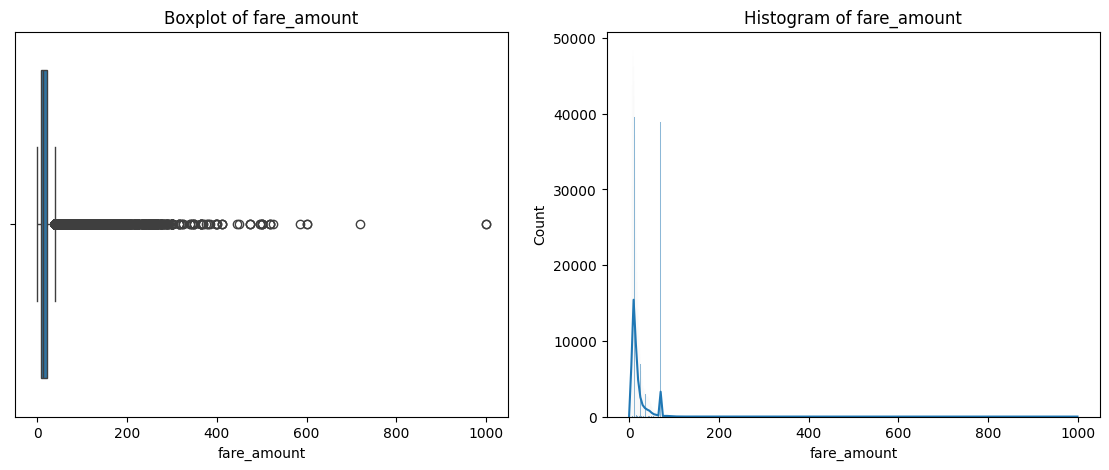

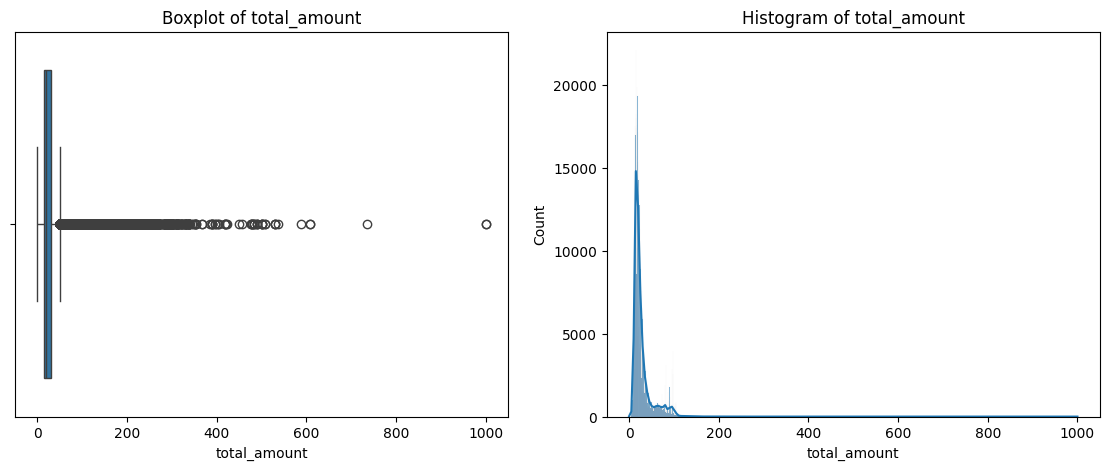

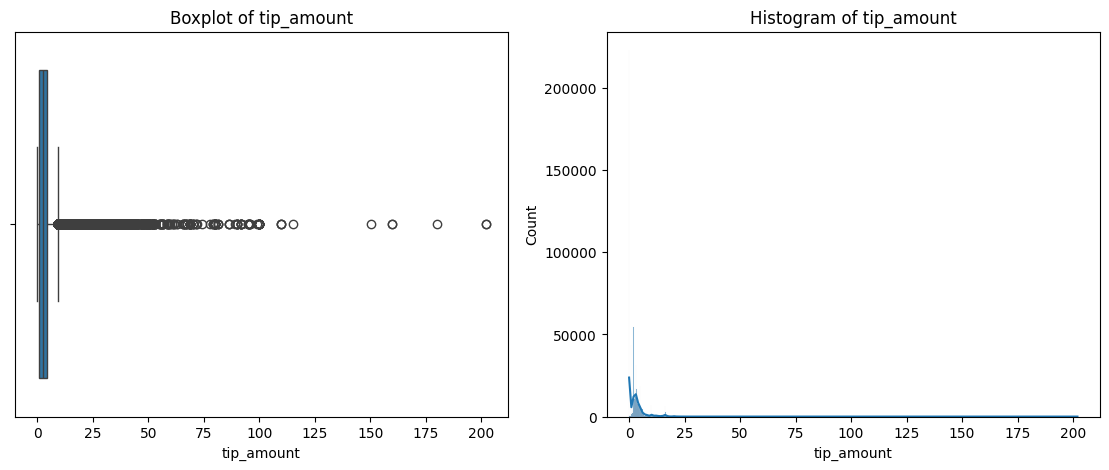

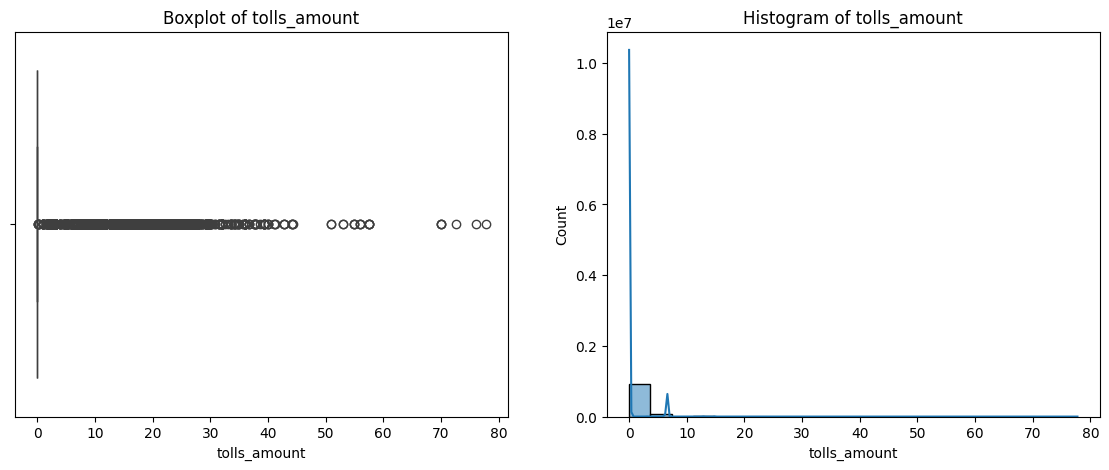

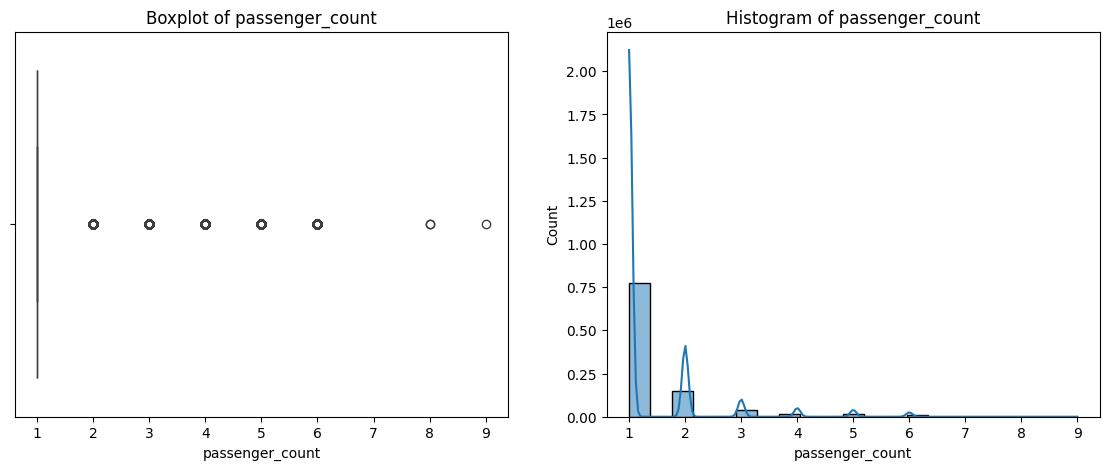

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select important numerical columns
columns_to_check = ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount', 'tolls_amount', 'passenger_count']

# Create boxplots and histograms for each column
for col in columns_to_check:
    plt.figure(figsize=(14,5))

    # Boxplot
    plt.subplot(1,2,1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

    # Histogram
    plt.subplot(1,2,2)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')

    plt.show()

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [ ]:
# remove passenger_count > 6
df = df[df['passenger_count'] <= 6]

In [ ]:
# Continue with outlier handling

df[(df['trip_distance'] < 0.1)]


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
127             1  2023-01-01 00:45:06   2023-01-01 00:54:06              1.0   
280             2  2023-01-01 01:34:06   2023-01-01 01:34:14              2.0   
302             2  2023-01-01 01:03:52   2023-01-01 01:05:27              1.0   
305             1  2023-01-01 01:26:38   2023-01-01 01:27:12              1.0   
306             2  2023-01-01 01:20:00   2023-01-01 01:20:02              4.0   
...           ...                  ...                   ...              ...   
1048287         1  2023-03-14 16:44:56   2023-03-14 17:41:29              1.0   
1048391         2  2023-03-14 16:17:26   2023-03-14 16:17:37              1.0   
1048460         2  2023-03-14 17:08:21   2023-03-14 17:08:24              5.0   
1048465         2  2023-03-14 17:33:45   2023-03-14 17:33:57              1.0   
1048471         2  2023-03-14 17:09:39   2023-03-14 17:20:54              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
127               0.00         1.0                  N            48   
280               0.00         5.0                  N           265   
302               0.02         1.0                  N           142   
305               0.00         5.0                  N           229   
306               0.00         5.0                  N           264   
...                ...         ...                ...           ...   
1048287           0.00        99.0                  N           166   
1048391           0.05         1.0                  N           138   
1048460           0.00         5.0                  N           100   
1048465           0.02         1.0                  N           198   
1048471           0.00         1.0                  N           264   

         DOLocationID  payment_type  ...  extra  mta_tax  tip_amount  \
127                48             2  ...    3.5      0.5        0.00   
280               265             1  ...    0.0      0.0       10.20   
302               142             2  ...    1.0      0.5        0.00   
305               229             1  ...    0.0      0.0        0.00   
306               264             1  ...    0.0      0.0        0.80   
...               ...           ...  ...    ...      ...         ...   
1048287           191             1  ...    0.0      0.5        0.00   
1048391           138             4  ...    7.5      0.5        0.00   
1048460           264             1  ...    0.0      0.5       18.30   
1048465           198             4  ...    2.5      0.5        0.00   
1048471           264             1  ...    2.5      0.5        2.94   

         tolls_amount  improvement_surcharge  total_amount  \
127              0.00                    1.0         13.60   
280              0.00                    1.0         61.20   
302              0.00                    1.0          8.70   
305              0.00                    1.0          6.00   
306              0.00                    1.0         46.80   
...               ...                    ...           ...   
1048287          6.55                    1.0         60.55   
1048391          0.00                    1.0         13.25   
1048460          0.00                    1.0        109.80   
1048465          0.00                    1.0          7.00   
1048471          0.00                    1.0         17.64   

         congestion_surcharge  pickup_date pickup_hour  airport_fee  
127                       2.5   2023-01-01           0         0.00  
280                       0.0   2023-01-01           1         0.00  
302                       2.5   2023-01-01           1         0.00  
305                       0.0   2023-01-01           1         0.00  
306                       0.0   2023-01-01           1         0.00  
...                       ...          ...         ...          ...  
1048287                   0.0   2023-03-14          16         0.00  
1048391      

In [ ]:
df = df[df['trip_distance'] >= 0.1]
df=df[df['fare_amount'] <300]

In [ ]:
df.shape

(988630, 21)

In [ ]:
df = df[df['trip_distance'] <= 250]


In [ ]:
df['payment_type'].value_counts()

payment_type
1    810957
2    168719
4      5772
3      3171
Name: count, dtype: int64

In [ ]:
df = df[~((df['fare_amount'] <= 0) & (df['PULocationID'] != df['DOLocationID']))]


In [ ]:
df.shape

(988512, 21)

In [ ]:
df[df['trip_distance']<0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, pickup_date, pickup_hour, airport_fee]
Index: []

[0 rows x 21 columns]

In [ ]:
negative_values = (df.select_dtypes(include='number') < 0).sum()

# Display columns with negative values
negative_values[negative_values > 0]

Series([], dtype: int64)

In [ ]:
# Do any columns need standardising?



## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [ ]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'pickup_date',
 'pickup_hour',
 'airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

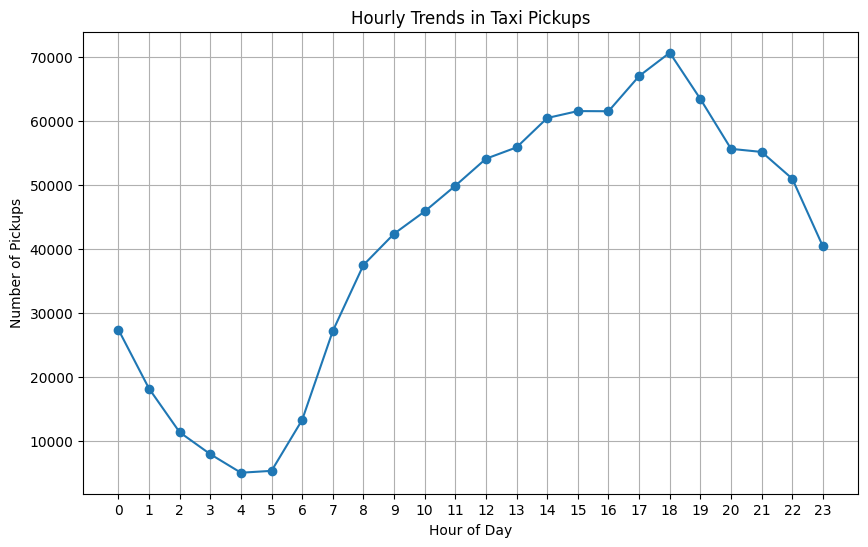

In [ ]:
# Find and show the hourly trends in taxi pickups

# Group by hour and count pickups
hourly_pickups = df.groupby('pickup_hour').size().reset_index(name='num_pickups')

# Plotting the trend
plt.figure(figsize=(10,6))
plt.plot(hourly_pickups['pickup_hour'], hourly_pickups['num_pickups'], marker='o')
plt.title('Hourly Trends in Taxi Pickups')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()


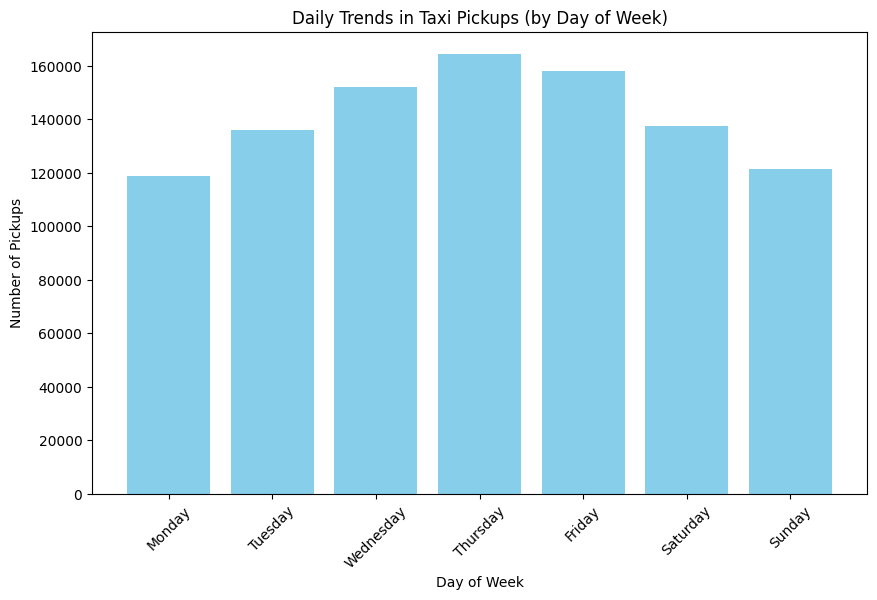

In [ ]:
# Find and show the daily trends in taxi pickups (days of the week)
# Extract day name from pickup datetime
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day_name()

# To keep days in week order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day name and count pickups
daily_pickups = df.groupby('pickup_day').size().reindex(days_order).reset_index(name='num_pickups')

# Plotting
plt.figure(figsize=(10,6))
plt.bar(daily_pickups['pickup_day'], daily_pickups['num_pickups'], color='skyblue')
plt.title('Daily Trends in Taxi Pickups (by Day of Week)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.show()


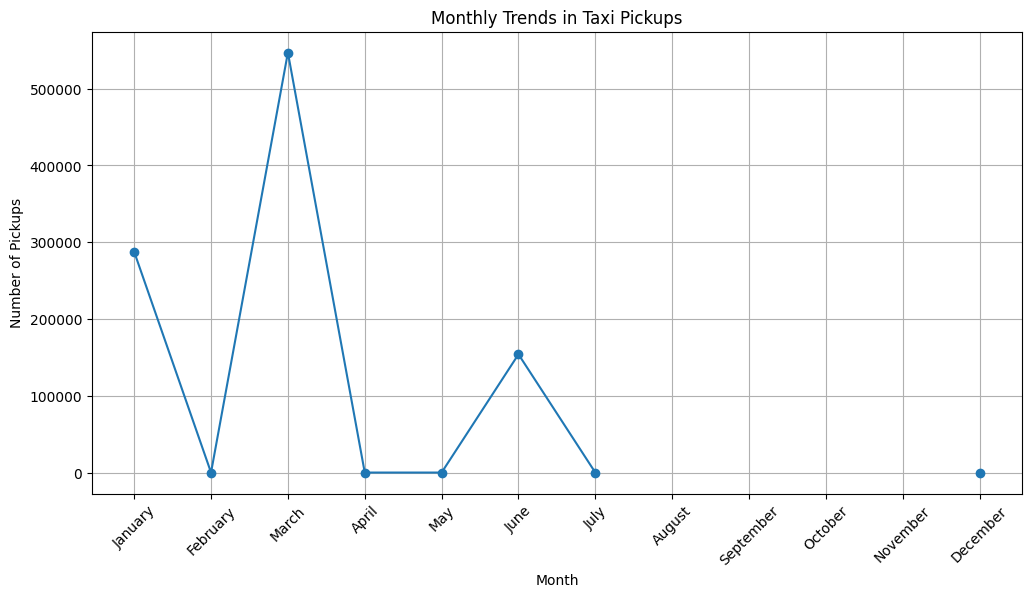

In [ ]:
# Show the monthly trends in pickups

# Extract month name from pickup datetime
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month_name()

# To keep months in calendar order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December']

# Group by month and count pickups
monthly_pickups = df.groupby('pickup_month').size().reindex(months_order).reset_index(name='num_pickups')

# Plotting
plt.figure(figsize=(12,6))
plt.plot(monthly_pickups['pickup_month'], monthly_pickups['num_pickups'], marker='o', linestyle='-')
plt.title('Monthly Trends in Taxi Pickups')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [ ]:
# Analyse the above parameters
financial_cols = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

for col in financial_cols:
    zero_count = (df[col] == 0).sum()
    negative_count = (df[col] < 0).sum()
    print(f"Column '{col}': Zero values = {zero_count}, Negative values = {negative_count}")



Column 'fare_amount': Zero values = 31, Negative values = 0
Column 'tip_amount': Zero values = 211467, Negative values = 0
Column 'total_amount': Zero values = 9, Negative values = 0
Column 'trip_distance': Zero values = 0, Negative values = 0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

In [ ]:
cols_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

df_filtered = df[(df[cols_to_check] > 0).all(axis=1)].copy()

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [ ]:
# Create a df with non zero entries for the selected parameters.

df_filtered = df[
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0) &
    (df['total_amount'] > 0) &
    (df['tip_amount'] >= 0) &  # Tips can be 0 if no tip given
    (df['tolls_amount'] >= 0)  # Tolls can be 0 if no toll route used
]

print(f"Remaining rows after removing invalid zero/negative entries: {df_filtered.shape[0]}")

Remaining rows after removing invalid zero/negative entries: 988481


In [ ]:
# Suspicious entries where trip_distance is 0 but pickup and drop zones are different
suspicious = df[(df['trip_distance'] == 0) & (df['PULocationID'] != df['DOLocationID'])]
print(f"Suspicious zero distance trips in different zones: {suspicious.shape[0]}")

Suspicious zero distance trips in different zones: 0


In [ ]:
df.describe()

VendorID           tpep_pickup_datetime  \
count  988512.000000                         988512   
mean        1.736066  2023-03-13 02:12:46.025175040   
min         1.000000            2022-12-31 23:51:30   
25%         1.000000     2023-01-27 17:24:59.500000   
50%         2.000000            2023-03-10 20:13:39   
75%         2.000000            2023-03-25 19:52:10   
max         2.000000            2023-07-01 00:00:51   
std         0.440764                            NaN   

               tpep_dropoff_datetime  passenger_count  trip_distance  \
count                         988512    988512.000000  988512.000000   
mean   2023-03-13 02:29:25.309127424         1.381872       3.458024   
min              2022-12-31 23:56:06         1.000000       0.100000   
25%              2023-01-27 17:41:20         1.000000       1.100000   
50%              2023-03-10 20:29:53         1.000000       1.800000   
75%              2023-03-25 20:07:37         1.000000       3.400000   
max              2023-07-01 18:21:41         6.000000      71.420000   
std                              NaN         0.881192       4.450892   

          RatecodeID   PULocationID   DOLocationID   payment_type  \
count  988512.000000  988512.000000  988512.000000  988512.000000   
mean        1.502188     165.988824     164.335277       1.194463   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000     132.000000     114.000000       1.000000   
50%         1.000000     162.000000     162.000000       1.000000   
75%         1.000000     234.000000     234.000000       1.000000   
max        99.000000     265.000000     265.000000       4.000000   
std         6.603673      63.585347      69.726512       0.444947   

         fare_amount          extra        mta_tax     tip_amount  \
count  988512.000000  988512.000000  988512.000000  988512.000000   
mean       18.996075       1.646450       0.497563       3.502798   
min         0.000000       0.000000       0.000000       0.000000   
25%         9.300000       0.000000       0.500000       1.000000   
50%        12.800000       1.000000       0.500000       2.800000   
75%        20.500000       2.500000       0.500000       4.340000   
max       299.800000      13.750000       4.000000     202.000000   
std        17.117937       1.815582       0.035588       3.874860   

        tolls_amount  improvement_surcharge   total_amount  \
count  988512.000000          988512.000000  988512.000000   
mean        0.559708               0.999409      28.007681   
min         0.000000               0.000000       0.000000   
25%         0.000000               1.000000      15.750000   
50%         0.000000               1.000000      20.540000   
75%         0.000000               1.000000      29.450000   
max        77.750000               1.000000     355.070000   
std         2.073885               0.020505      21.659838   

       congestion_surcharge                    pickup_date    pickup_hour  \
count         988512.000000                         988512  988512.000000   
mean               2.327754  2023-03-12 11:24:25.417111552      14.304495   
min                0.000000            2022-12-31 00:00:00       0.000000   
25%                2.500000            2023-01-27 00:00:00      11.000000   
50%                2.500000            2023-03-10 00:00:00      15.000000   
75%                2.500000            2023-03-25 00:00:00      19.000000   
max                2.500000            2023-07-01 00:00:00      23.000000   
std                0.633204                            NaN       5.763440   

         airport_fee  
count  988512.000000  
mean        0.114746  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.750000  
std         0.377425

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

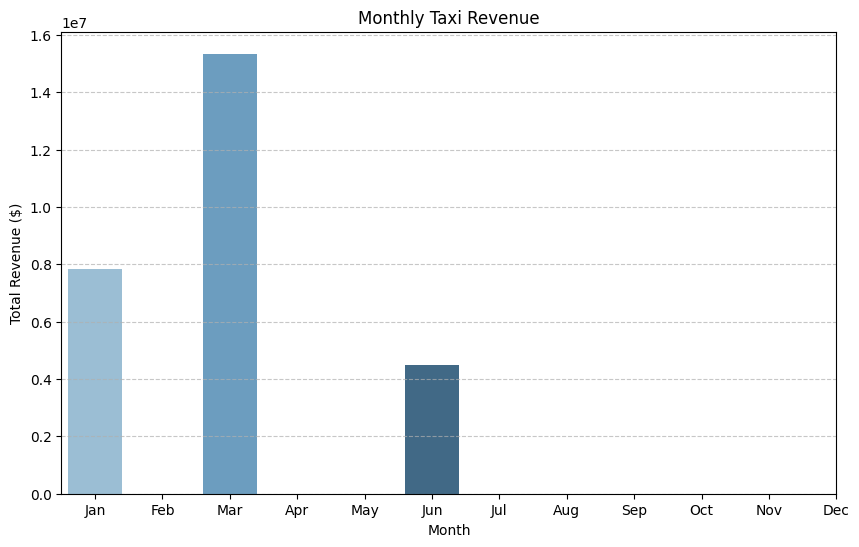

In [ ]:
# Group data by month and analyse monthly revenue

# Ensure pickup datetime is in datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract month from pickup datetime
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

# Group by month and sum the revenue (use 'total_amount' for more complete revenue)
monthly_revenue = df.groupby('pickup_month')['total_amount'].sum().reset_index()

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x='pickup_month', y='total_amount', data=monthly_revenue, palette='Blues_d')
plt.title('Monthly Taxi Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.xticks(range(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [ ]:
# Calculate proportion of each quarter
# Ensure pickup datetime is in datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract quarter
df['pickup_quarter'] = df['tpep_pickup_datetime'].dt.quarter

# Group by quarter and sum total revenue
quarterly_revenue = df.groupby('pickup_quarter')['total_amount'].sum().reset_index()

# Calculate proportion
total_revenue = quarterly_revenue['total_amount'].sum()
quarterly_revenue['proportion'] = quarterly_revenue['total_amount'] / total_revenue

# Display as percentage
quarterly_revenue['proportion'] = quarterly_revenue['proportion'] * 100

print(quarterly_revenue)


   pickup_quarter  total_amount  proportion
0               1   23187658.91   83.752505
1               2    4498207.82   16.247271
2               3         34.96    0.000126
3               4         27.00    0.000098


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

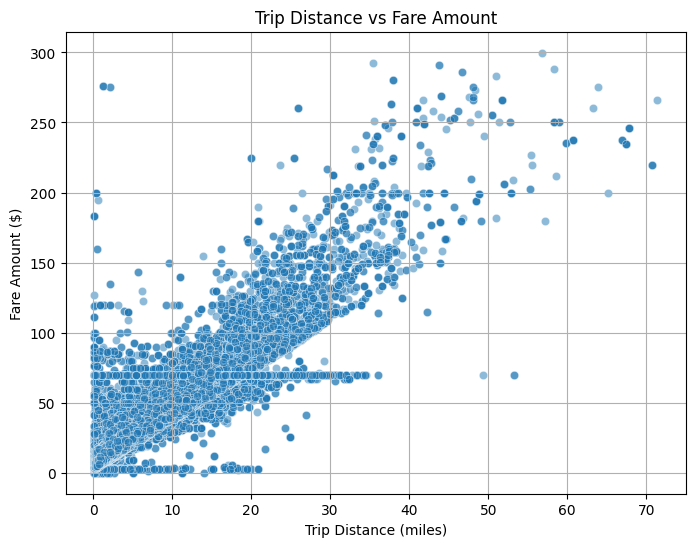

Correlation between trip_distance and fare_amount: 0.9602


In [ ]:
# Show how trip fare is affected by distance

# Filter out zero trip_distance
filtered_df = df[df['trip_distance'] > 0]

# Plotting the scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=filtered_df, alpha=0.5)
plt.title('Trip Distance vs Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

# Calculate correlation
correlation = filtered_df['trip_distance'].corr(filtered_df['fare_amount'])
print(f"Correlation between trip_distance and fare_amount: {correlation:.4f}")

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

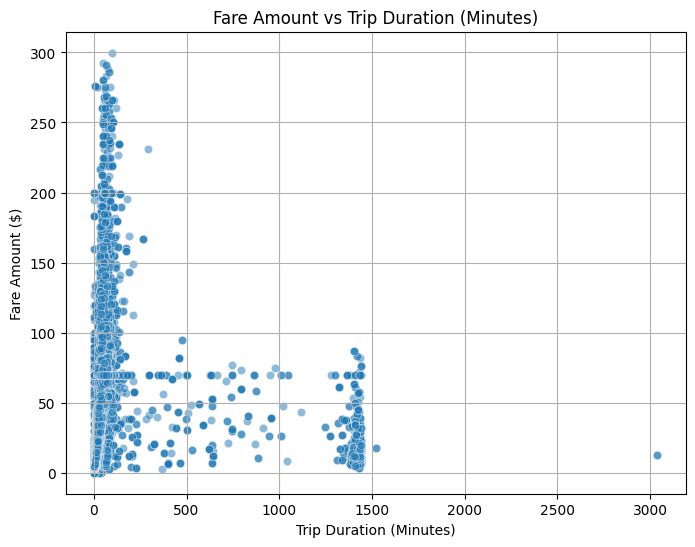

Correlation between fare_amount and trip_duration: 0.2574


In [ ]:
# Show relationship between fare and trip duration

# Ensure trip duration is in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filter to remove zero or negative durations (if any)
df_duration = df[df['trip_duration'] > 0]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='trip_duration', y='fare_amount', data=df_duration, alpha=0.5)
plt.title('Fare Amount vs Trip Duration (Minutes)')
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

# Correlation
correlation_fd = df_duration['fare_amount'].corr(df_duration['trip_duration'])
print(f"Correlation between fare_amount and trip_duration: {correlation_fd:.4f}")

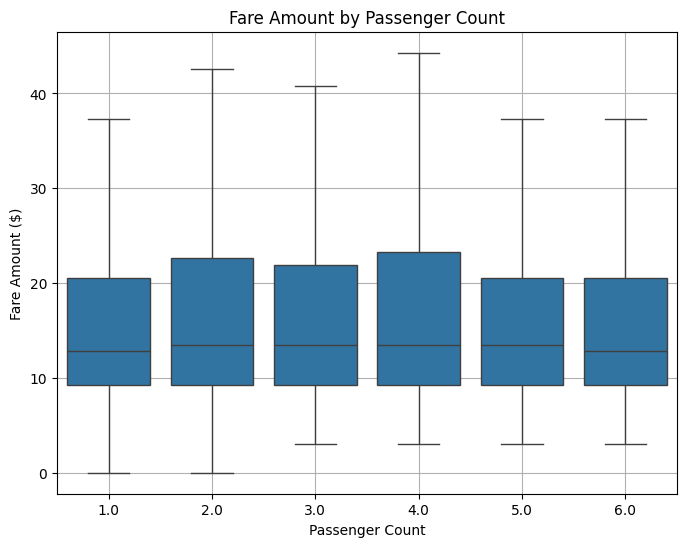

Correlation between fare_amount and passenger_count: 0.0307


In [ ]:
# Show relationship between fare and number of passengers
plt.figure(figsize=(8,6))
sns.boxplot(x='passenger_count', y='fare_amount', data=df, showfliers=False)
plt.title('Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

# Correlation
correlation_fp = df['fare_amount'].corr(df['passenger_count'])
print(f"Correlation between fare_amount and passenger_count: {correlation_fp:.4f}")


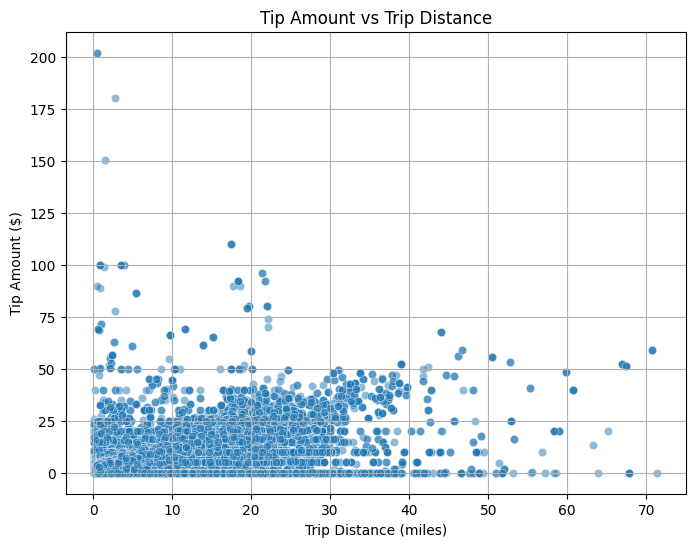

Correlation between tip_amount and trip_distance: 0.6040


In [ ]:
# Show relationship between tip and trip distance
# Filter to remove zero or negative trip_distance (if any)
df_td = df[df['trip_distance'] > 0]

plt.figure(figsize=(8,6))
sns.scatterplot(x='trip_distance', y='tip_amount', data=df_td, alpha=0.5)
plt.title('Tip Amount vs Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount ($)')
plt.grid(True)
plt.show()

# Correlation
correlation_tt = df_td['tip_amount'].corr(df_td['trip_distance'])
print(f"Correlation between tip_amount and trip_distance: {correlation_tt:.4f}")


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [ ]:
df.head(
)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
5         1  2023-01-01 00:42:56   2023-01-01 01:16:33              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
5           7.10         1.0                  N           246            37   

   payment_type  ...  improvement_surcharge  total_amount  \
0             2  ...                    1.0         41.15   
1             1  ...                    1.0         15.48   
2             2  ...                    1.0         16.40   
3             2  ...                    1.0         11.50   
5             1  ...                    1.0         47.40   

   congestion_surcharge  pickup_date  pickup_hour  airport_fee  pickup_day  \
0                   0.0   2023-01-01            0         1.25      Sunday   
1                   2.5   2023-01-01            0         0.00      Sunday   
2                   2.5   2023-01-01            0         0.00      Sunday   
3                   2.5   2023-01-01            0         0.00      Sunday   
5                   2.5   2023-01-01            0         0.00      Sunday   

   pickup_month pickup_quarter  trip_duration  
0             1              1      15.950000  
1             1              1       5.083333  
2             1              1      10.550000  
3             1              1       5.416667  
5             1              1      33.616667  

[5 rows x 25 columns]

payment_type
1    810954
2    168644
4      5757
3      3157
Name: count, dtype: int64
payment_type
1    82.037851
2    17.060390
4     0.582391
3     0.319369
Name: proportion, dtype: float64


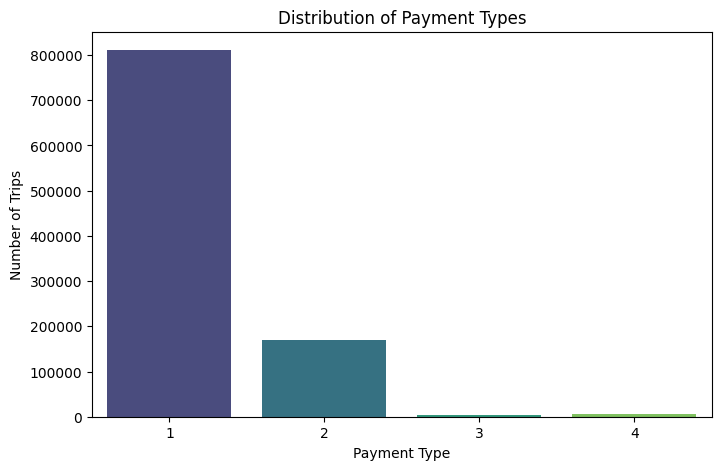

In [ ]:
# Analyse the distribution of different payment types (payment_type).


# Step 1: Count occurrences of each payment_type
payment_counts = df['payment_type'].value_counts()
print(payment_counts)

# Step 2: Calculate percentage distribution
payment_percent = df['payment_type'].value_counts(normalize=True) * 100
print(payment_percent)

# Step 3: Plotting the distribution as bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=payment_counts.index, y=payment_counts.values, palette='viridis')
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Number of Trips')
plt.show()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving taxi_zones.zip to taxi_zones.zip


In [ ]:
import zipfile
import os

# Unzip the folder and ensure it creates 'taxi_zones' directory
with zipfile.ZipFile('taxi_zones.zip', 'r') as zip_ref:
    zip_ref.extractall('taxi_zones')

In [ ]:
os.listdir('taxi_zones')


['taxi_zones']

In [ ]:
# !pip install geopandas
!pip install geopandas



**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [ ]:
os.listdir()


['.config',
 'taxi_zones.zip',
 'taxi_zones',
 'combined_sampled_data (3).xlsx',
 'taxi_zones.shp',
 'Taxi Zones',
 'sample_data']

In [ ]:
import os
import shutil

# Delete wrongly uploaded loose files/folders if they exist
if os.path.exists('taxi_zones.shp'):
    os.remove('taxi_zones.shp')
    print("Removed loose 'taxi_zones.shp'")

if os.path.exists('taxi_zones'):
    shutil.rmtree('taxi_zones')
    print("Removed wrongly extracted 'taxi_zones' folder")

# Confirm the structure
print("Current directory contents:")
print(os.listdir())

# Check if 'Taxi Zones' folder has the correct files
print("\nFiles inside 'Taxi Zones':")
print(os.listdir('Taxi Zones'))

Removed loose 'taxi_zones.shp'
Removed wrongly extracted 'taxi_zones' folder
Current directory contents:
['.config', 'taxi_zones.zip', 'combined_sampled_data (3).xlsx', 'Taxi Zones', 'sample_data']

Files inside 'Taxi Zones':
['taxi_zones']


In [ ]:
# Search the entire workspace for .shp file
for root, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith('.shp'):
            print("Found shapefile:", os.path.join(root, file))

Found shapefile: ./Taxi Zones/taxi_zones/taxi_zones.shp


In [ ]:
# import geopandas as gpd
import geopandas as gpd

# Read the shapefile from the extracted folder
zones = gpd.read_file('./Taxi Zones/taxi_zones/taxi_zones.shp')
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<Figure size 1200x1200 with 0 Axes>

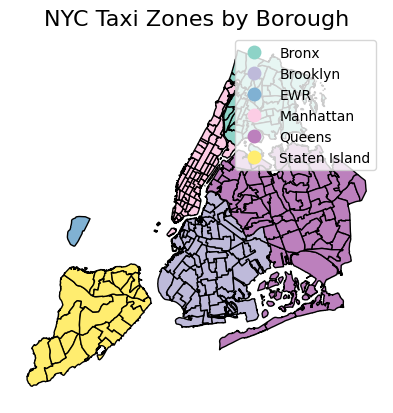

In [ ]:
# print(zones.info())
# zones.plot()
import matplotlib.pyplot as plt

# Set figure size for better clarity
plt.figure(figsize=(12, 12))

# Plot the zones
zones.plot(column='borough', cmap='Set3', edgecolor='black', legend=True)

# Add title and remove axes
plt.title('NYC Taxi Zones by Borough', fontsize=16)
plt.axis('off')

plt.show()

Now, you have to merge the trip records and zones data using the location IDs.

*   List item

> Add blockquote


*   List item





**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [ ]:
# Merge zones and trip records using locationID and PULocationID

# Merge trip records with zones GeoDataFrame on PULocationID and LocationID
trips_with_pickup_zones = df_filtered.merge(
    zones[['LocationID', 'zone', 'borough', 'geometry']],
    how='left',
    left_on='PULocationID',
    right_on='LocationID'
)

# Rename columns to clarify these are pickup zones
trips_with_pickup_zones = trips_with_pickup_zones.rename(columns={
    'zone': 'pickup_zone',
    'borough': 'pickup_borough',
    'geometry': 'pickup_zone_geometry'
})

# Drop redundant LocationID column (from zones)
trips_with_pickup_zones = trips_with_pickup_zones.drop(columns=['LocationID'])

# Display first few rows
trips_with_pickup_zones.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         1  2023-01-01 00:42:56   2023-01-01 01:16:33              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
4           7.10         1.0                  N           246            37   

   payment_type  ...  total_amount  congestion_surcharge  pickup_date  \
0             2  ...         41.15                   0.0   2023-01-01   
1             1  ...         15.48                   2.5   2023-01-01   
2             2  ...         16.40                   2.5   2023-01-01   
3             2  ...         11.50                   2.5   2023-01-01   
4             1  ...         47.40                   2.5   2023-01-01   

   pickup_hour  airport_fee  pickup_day  pickup_month  \
0            0         1.25      Sunday       January   
1            0         0.00      Sunday       January   
2            0         0.00      Sunday       January   
3            0         0.00      Sunday       January   
4            0         0.00      Sunday       January   

                 pickup_zone pickup_borough  \
0          LaGuardia Airport         Queens   
1             Midtown Center      Manhattan   
2      Upper East Side South      Manhattan   
3        Lincoln Square West      Manhattan   
4  West Chelsea/Hudson Yards      Manhattan   

                                pickup_zone_geometry  
0  MULTIPOLYGON (((1019904.219 225677.983, 102031...  
1  POLYGON ((991081.026 214453.698, 990952.644 21...  
2  POLYGON ((993633.442 216961.016, 993507.232 21...  
3  POLYGON ((989338.1 223572.253, 989368.225 2235...  
4  POLYGON ((983031.177 217138.506, 983640.32 216...  

[5 rows x 26 columns]

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [ ]:
# Group data by location and calculate the number of trips

# Group by pickup location and count trips
trip_counts_by_location = df_filtered.groupby('PULocationID').size().reset_index(name='trip_count')

trip_counts_by_location

PULocationID  trip_count
0               1           8
1               3          15
2               4         913
3               5           5
4               6          12
..            ...         ...
238           261        4570
239           262       13104
240           263       20356
241           264       10060
242           265         131

[243 rows x 2 columns]

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [ ]:
# Merge trip counts back to the zones GeoDataFrame

# Group trips by pickup location and count
trip_counts = df_filtered.groupby('PULocationID').size().reset_index(name='trip_count')

# Merge trip counts with zones GeoDataFrame on LocationID
zones_with_trip_counts = zones.merge(
    trip_counts,
    how='left',
    left_on='LocationID',
    right_on='PULocationID'
)

# Replace NaN trip counts with 0 for zones without trips
zones_with_trip_counts['trip_count'] = zones_with_trip_counts['trip_count'].fillna(0)

# Drop redundant PULocationID column
zones_with_trip_counts = zones_with_trip_counts.drop(columns=['PULocationID'])

zones_with_trip_counts.head()


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   trip_count  
0         8.0  
1         0.0  
2        15.0  
3       913.0  
4         5.0

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

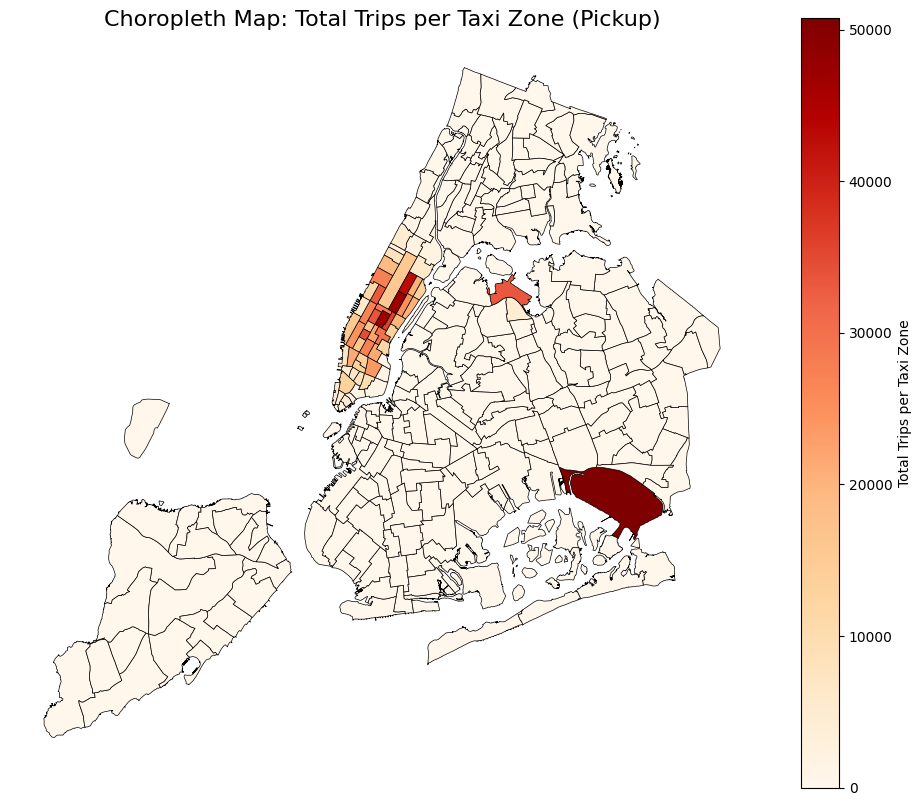

In [ ]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the map and display it

import matplotlib.pyplot as plt


# Plot the GeoDataFrame zones_with_trip_counts on this axis
zones_with_trip_counts.plot(
    column='trip_count',                # The data column to visualize
    ax=ax,                            # Plot on the defined axis
    legend=True,                      # Show color legend
    cmap='OrRd',                     # Color map (Orange-Red)
    edgecolor='black',               # Zone borders
    linewidth=0.5,
    legend_kwds={
        'label': "Total Trips per Taxi Zone",  # Legend label
        'orientation': "vertical"               # Legend orientation
    }
)

# Add title
ax.set_title('Choropleth Map: Total Trips per Taxi Zone (Pickup)', fontsize=16)

# Remove axis ticks and labels for cleaner look
ax.set_axis_off()

# Display the plot
plt.show()

In [ ]:
# can you try displaying the zones DF sorted by the number of trips?
# Sort zones by trip_count in descending order
zones_sorted = zones_with_trip_counts.sort_values(by='trip_count', ascending=False)

# Display the sorted DataFrame (showing relevant columns)
zones_sorted[['LocationID', 'zone', 'borough', 'trip_count']].head(10)


LocationID                          zone    borough  trip_count
131         132                   JFK Airport     Queens     50795.0
236         237         Upper East Side South  Manhattan     47041.0
160         161                Midtown Center  Manhattan     46439.0
235         236         Upper East Side North  Manhattan     42787.0
161         162                  Midtown East  Manhattan     36045.0
185         186  Penn Station/Madison Sq West  Manhattan     34541.0
229         230     Times Sq/Theatre District  Manhattan     33685.0
137         138             LaGuardia Airport     Queens     33327.0
141         142           Lincoln Square East  Manhattan     32946.0
169         170                   Murray Hill  Manhattan     29895.0

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [ ]:
df_filtered.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'pickup_date', 'pickup_hour',
       'airport_fee', 'pickup_day', 'pickup_month'],
      dtype='object')

In [ ]:
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

df_filtered['trip_duration'] = (df_filtered['tpep_dropoff_datetime'] - df_filtered['tpep_pickup_datetime']).dt.total_seconds() / 60  # duration in minutes

In [ ]:
# Step 1: Group by route and hour to get average distance and average trip duration
route_hour_stats = df_filtered.groupby(
    ['PULocationID', 'DOLocationID', 'pickup_hour']
).agg({
    'trip_distance': 'mean',
    'trip_duration': 'mean'
}).reset_index()

# Step 2: Calculate average speed (distance / duration)
# Make sure trip_duration is in hours to get speed in miles per hour (or km/h)
# If trip_duration is in minutes, divide by 60
route_hour_stats['avg_speed'] = route_hour_stats['trip_distance'] / (route_hour_stats['trip_duration'] / 60)

# Step 3: Identify slow routes (for example, avg_speed < threshold, e.g., 5 mph)
slow_routes = route_hour_stats[route_hour_stats['avg_speed'] < 5]

# Show slow routes sorted by lowest average speed
slow_routes_sorted = slow_routes.sort_values(by='avg_speed')

slow_routes_sorted.head(10)

PULocationID  DOLocationID  pickup_hour  trip_distance  trip_duration  \
69072           243           243           23         0.6800    1423.650000   
40517           151            24            1         0.5625    1078.045833   
4943             48             7           13         1.8600    3040.516667   
1340             13           209            7         0.9200    1409.050000   
2702             40            65           21         1.1200    1434.433333   
45261           162           162            4         1.5400    1426.366667   
28441           134           265           15         0.1000      81.266667   
15355            88           144            0         1.7800    1425.466667   
4542             45            79            1         1.8500    1430.466667   
8115             67           215           15         0.1000      76.833333   

       avg_speed  
69072   0.028659  
40517   0.031307  
4943    0.036704  
1340    0.039175  
2702    0.046848  
45261   0.064780  
28441   0.073831  
15355   0.074923  
4542    0.077597  
8115    0.078091

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

Busiest hour: 18 with 70654 trips


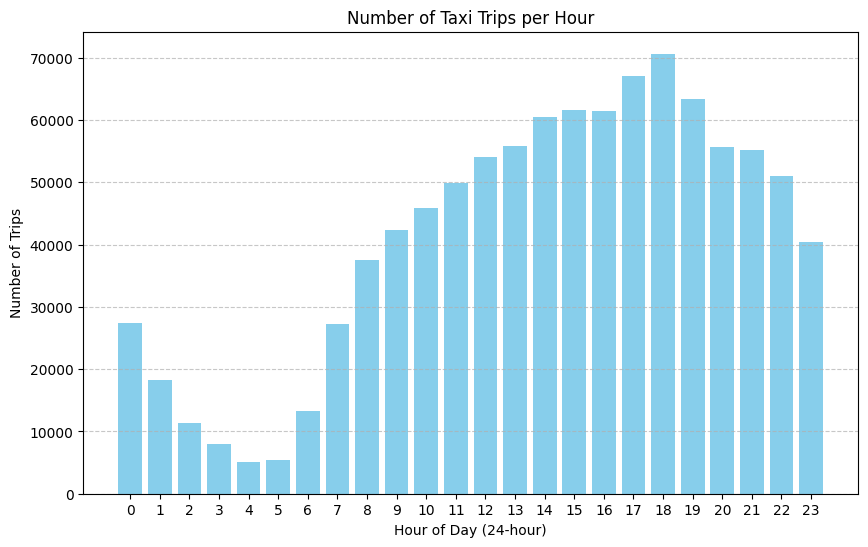

In [ ]:
# Visualise the number of trips per hour and find the busiest hour
import matplotlib.pyplot as plt

# Group trips by pickup hour and count the number of trips
trips_per_hour = df_filtered.groupby('pickup_hour').size().reset_index(name='trip_count')

# Find the busiest hour
busiest_hour = trips_per_hour.loc[trips_per_hour['trip_count'].idxmax()]

print(f"Busiest hour: {busiest_hour['pickup_hour']} with {busiest_hour['trip_count']} trips")

# Plot the number of trips per hour
plt.figure(figsize=(10,6))
plt.bar(trips_per_hour['pickup_hour'], trips_per_hour['trip_count'], color='skyblue')
plt.xlabel('Hour of Day (24-hour)')
plt.ylabel('Number of Trips')
plt.title('Number of Taxi Trips per Hour')
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

Busiest hour (scaled): 18.0 with approx. 706540 trips


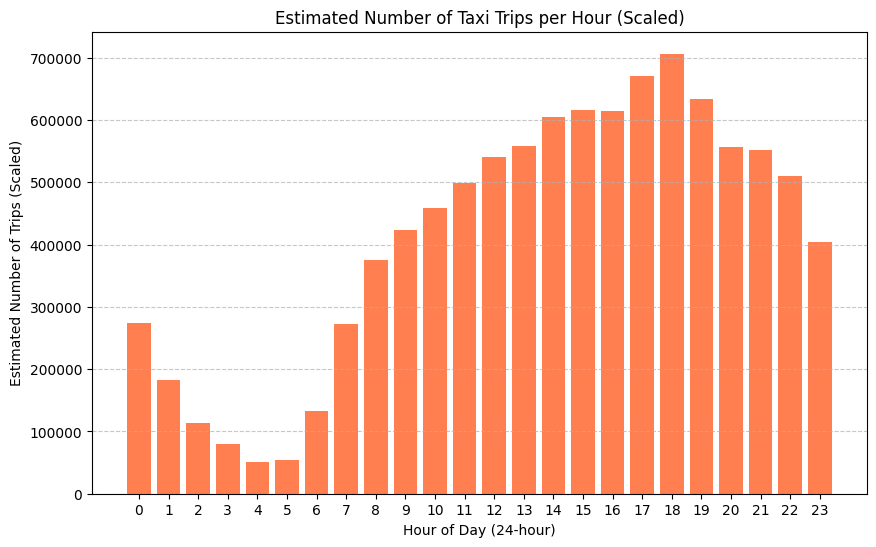

In [ ]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
# Define your sampling fraction (e.g., 0.1 for 10% sample)
sampling_fraction = 0.1  # <-- fill your actual fraction here

# Scale up the trips per hour
trips_per_hour['scaled_trip_count'] = trips_per_hour['trip_count'] / sampling_fraction

# Find the busiest hour based on scaled counts
busiest_hour_scaled = trips_per_hour.loc[trips_per_hour['scaled_trip_count'].idxmax()]

print(f"Busiest hour (scaled): {busiest_hour_scaled['pickup_hour']} with approx. {int(busiest_hour_scaled['scaled_trip_count'])} trips")

# Plot scaled trip counts
plt.figure(figsize=(10,6))
plt.bar(trips_per_hour['pickup_hour'], trips_per_hour['scaled_trip_count'], color='coral')
plt.xlabel('Hour of Day (24-hour)')
plt.ylabel('Estimated Number of Trips (Scaled)')
plt.title('Estimated Number of Taxi Trips per Hour (Scaled)')
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

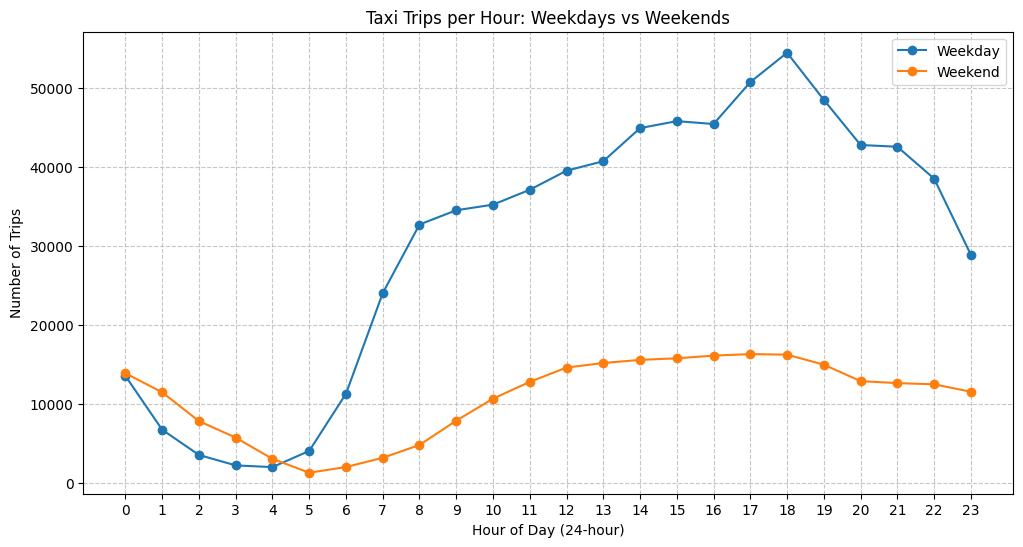

In [ ]:
# Compare traffic trends for the week days and weekends
# Add a new column to identify weekday or weekend
# Assuming 'pickup_day' column has day names like 'Monday', 'Tuesday', etc.
df_new = df_filtered.copy()  # or use your dataframe variable

df_new['day_type'] = df_new['pickup_day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Group by day_type and pickup_hour, count trips
trips_by_daytype_hour = df_new.groupby(['day_type', 'pickup_hour']).size().reset_index(name='trip_count')

# Pivot for plotting
pivot_df = trips_by_daytype_hour.pivot(index='pickup_hour', columns='day_type', values='trip_count').fillna(0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(pivot_df.index, pivot_df['Weekday'], label='Weekday', marker='o')
plt.plot(pivot_df.index, pivot_df['Weekend'], label='Weekend', marker='o')
plt.xlabel('Hour of Day (24-hour)')
plt.ylabel('Number of Trips')
plt.title('Taxi Trips per Hour: Weekdays vs Weekends')
plt.xticks(range(0,24))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [ ]:
# Find top 10 pickup and dropoff zones
# Top 10 Pickup Zones by trip count
top_pickup = df_filtered['PULocationID'].value_counts().head(10).reset_index()
top_pickup.columns = ['LocationID', 'pickup_trip_count']

# Top 10 Dropoff Zones by trip count
top_dropoff = df_filtered['DOLocationID'].value_counts().head(10).reset_index()
top_dropoff.columns = ['LocationID', 'dropoff_trip_count']
# Merge with zones GeoDataFrame to get zone names for pickups
top_pickup = top_pickup.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

# Merge with zones GeoDataFrame to get zone names for dropoffs
top_dropoff = top_dropoff.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

print("Top 10 Pickup Zones with Names:")
print(top_pickup)

print("\nTop 10 Dropoff Zones with Names:")
print(top_dropoff)

Top 10 Pickup Zones with Names:
   LocationID  pickup_trip_count                          zone
0         132              50795                   JFK Airport
1         237              47041         Upper East Side South
2         161              46439                Midtown Center
3         236              42787         Upper East Side North
4         162              36045                  Midtown East
5         186              34541  Penn Station/Madison Sq West
6         230              33685     Times Sq/Theatre District
7         138              33327             LaGuardia Airport
8         142              32946           Lincoln Square East
9         170              29895                   Murray Hill

Top 10 Dropoff Zones with Names:
   LocationID  dropoff_trip_count                       zone
0         236               44678      Upper East Side North
1         237               41708      Upper East Side South
2         161               38450             Midtown Cent

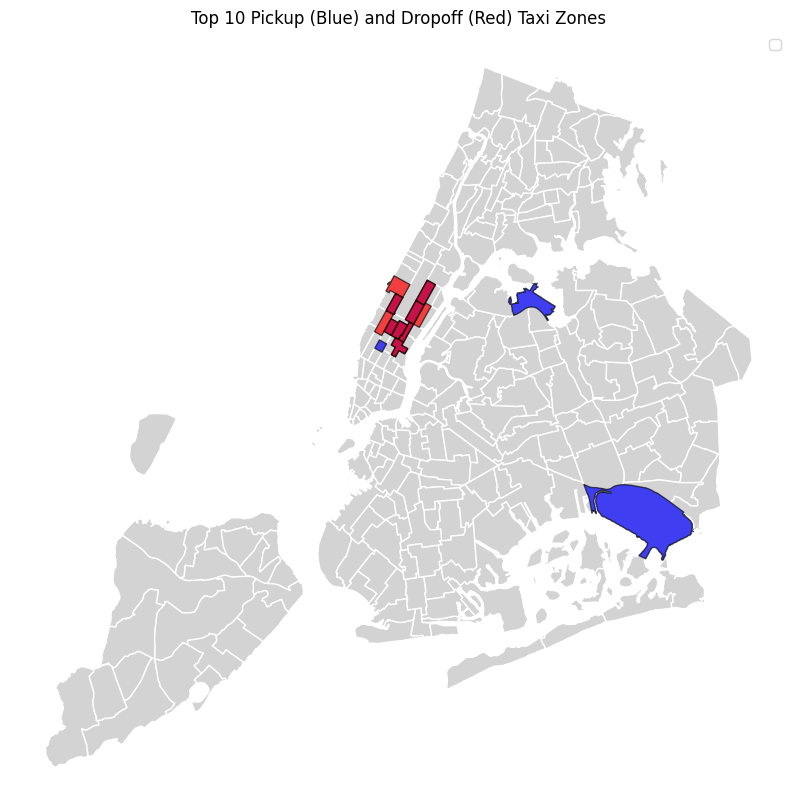

In [ ]:
import matplotlib.pyplot as plt

# Get top 10 pickup and dropoff LocationIDs
top_pickup_ids = top_pickup['LocationID'].tolist()
top_dropoff_ids = top_dropoff['LocationID'].tolist()

# Create subsets of zones for pickups and dropoffs
pickup_zones = zones[zones['LocationID'].isin(top_pickup_ids)]
dropoff_zones = zones[zones['LocationID'].isin(top_dropoff_ids)]

# Plot base map with all zones (light grey)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
zones.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot pickup zones in blue
pickup_zones.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label='Top Pickup Zones')

# Plot dropoff zones in red
dropoff_zones.plot(ax=ax, color='red', edgecolor='black', alpha=0.7, label='Top Dropoff Zones')

# Add legend and title
plt.legend()
plt.title('Top 10 Pickup (Blue) and Dropoff (Red) Taxi Zones')
plt.axis('off')
plt.show()

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

Top 10 zones with highest pickup/dropoff ratios:
   LocationID                          zone  pickup_count  dropoff_count  \
0         204             Rossville/Woodrow           6.0            0.0   
1          70                 East Elmhurst        4450.0          425.0   
2         132                   JFK Airport       50795.0         9851.0   
3         138             LaGuardia Airport       33327.0        11116.0   
4         186  Penn Station/Madison Sq West       34541.0        22019.0   
5         114       Greenwich Village South       13050.0         9356.0   
6          43                  Central Park       15786.0        11420.0   
7         249                  West Village       21473.0        16411.0   
8         162                  Midtown East       36045.0        28217.0   
9         161                Midtown Center       46439.0        38450.0   

   pickup_dropoff_ratio  
0                   inf  
1             10.470588  
2              5.156329  
3         

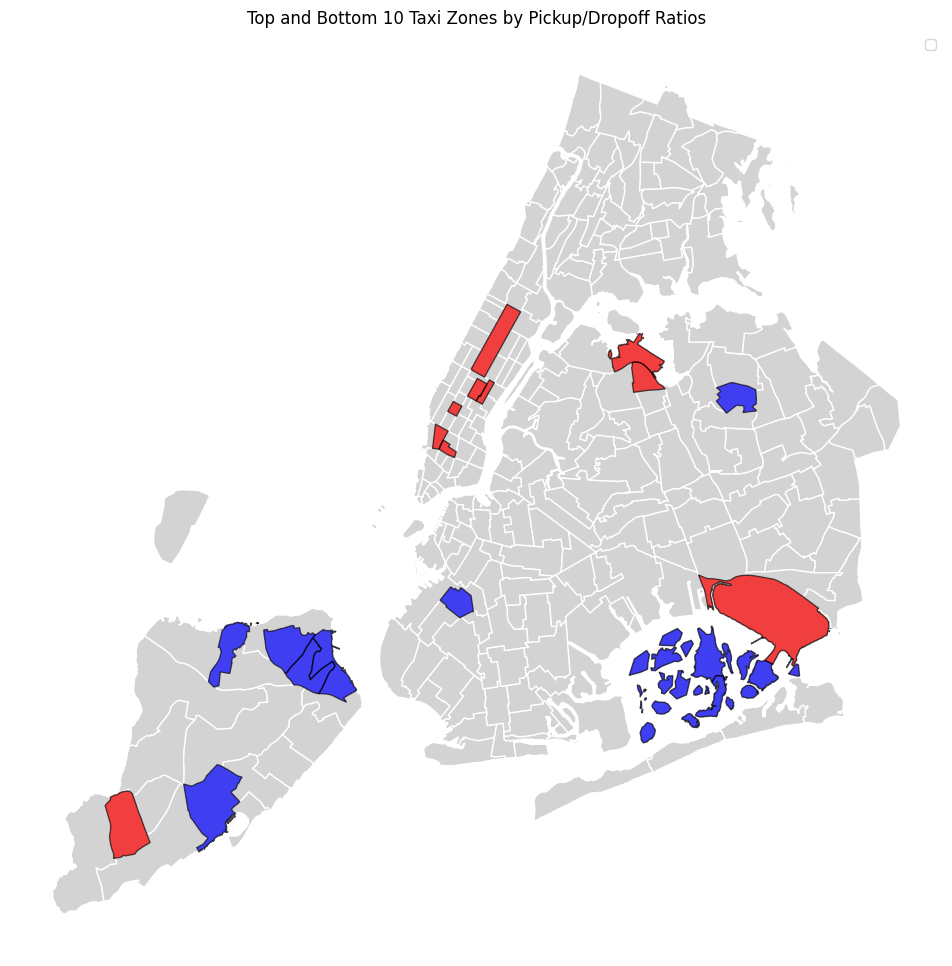

In [ ]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Step 1: Calculate pickups and dropoffs per zone
pickup_counts = df_filtered['PULocationID'].value_counts().reset_index()
pickup_counts.columns = ['LocationID', 'pickup_count']

dropoff_counts = df_filtered['DOLocationID'].value_counts().reset_index()
dropoff_counts.columns = ['LocationID', 'dropoff_count']

# Step 2: Merge counts and calculate pickup/dropoff ratio
zone_counts = pickup_counts.merge(dropoff_counts, on='LocationID', how='outer').fillna(0)
zone_counts['pickup_dropoff_ratio'] = zone_counts.apply(
    lambda row: row['pickup_count'] / row['dropoff_count'] if row['dropoff_count'] != 0 else float('inf'), axis=1
)

# Step 3: Get top 10 and bottom 10 zones by ratio
top_10_ratio = zone_counts.sort_values(by='pickup_dropoff_ratio', ascending=False).head(10)
bottom_10_ratio = zone_counts.sort_values(by='pickup_dropoff_ratio').head(10)

# Step 4: Add zone names
top_10_ratio = top_10_ratio.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
bottom_10_ratio = bottom_10_ratio.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

print("Top 10 zones with highest pickup/dropoff ratios:")
print(top_10_ratio[['LocationID', 'zone', 'pickup_count', 'dropoff_count', 'pickup_dropoff_ratio']])

print("\nBottom 10 zones with lowest pickup/dropoff ratios:")
print(bottom_10_ratio[['LocationID', 'zone', 'pickup_count', 'dropoff_count', 'pickup_dropoff_ratio']])

# Step 5: Plot on map

# Extract zones for top and bottom 10
top_zones = zones[zones['LocationID'].isin(top_10_ratio['LocationID'])]
bottom_zones = zones[zones['LocationID'].isin(bottom_10_ratio['LocationID'])]

fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Plot all zones lightly
zones.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot top zones (high pickup/dropoff ratio) in red
top_zones.plot(ax=ax, color='red', edgecolor='black', alpha=0.7, label='Top 10 Pickup/Dropoff Ratio')

# Plot bottom zones (low pickup/dropoff ratio) in blue
bottom_zones.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label='Bottom 10 Pickup/Dropoff Ratio')

plt.legend()
plt.title('Top and Bottom 10 Taxi Zones by Pickup/Dropoff Ratios')
plt.axis('off')
plt.show()

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

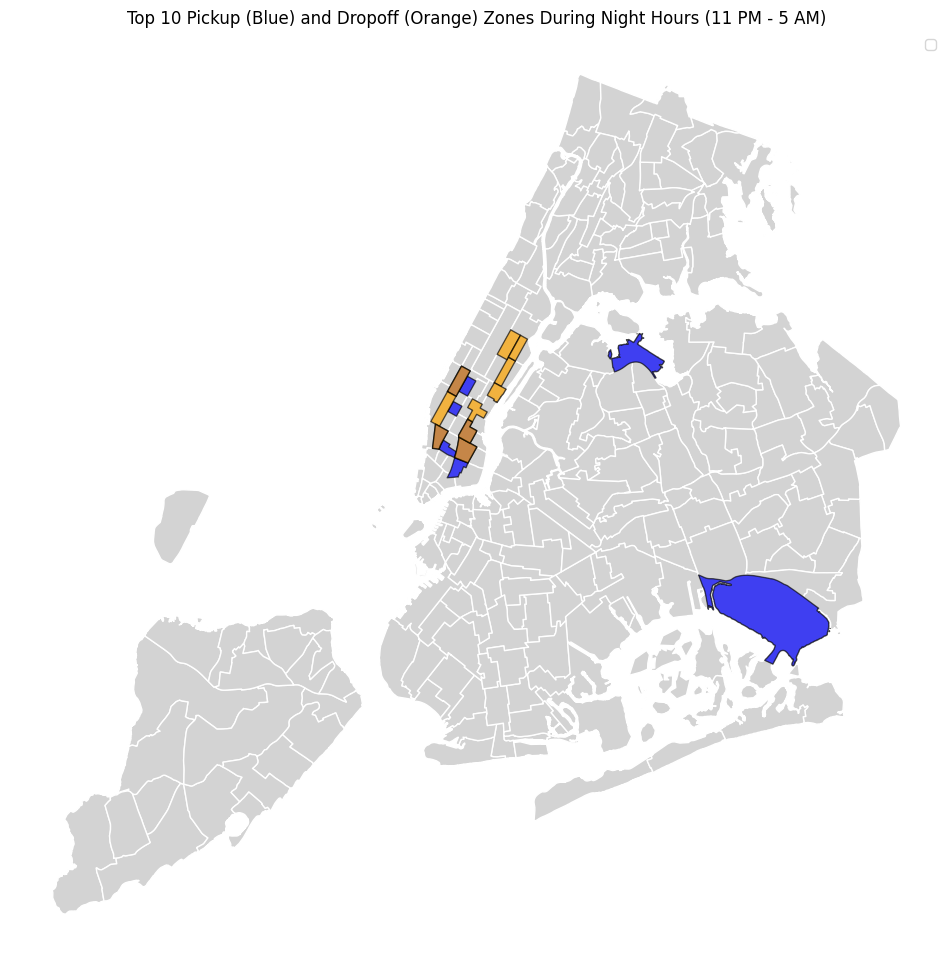

In [ ]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones


# Define night hours: 23 (11 PM) to 5 (5 AM)
night_hours = list(range(23, 24)) + list(range(0, 6))

# Filter trips during night hours
night_trips = df_filtered[df_filtered['pickup_hour'].isin(night_hours)]

# Top 10 pickups at night
top_night_pickup = night_trips['PULocationID'].value_counts().head(10).reset_index()
top_night_pickup.columns = ['LocationID', 'pickup_count']

# Top 10 dropoffs at night
top_night_dropoff = night_trips['DOLocationID'].value_counts().head(10).reset_index()
top_night_dropoff.columns = ['LocationID', 'dropoff_count']

# Merge with zones to get zone names and geometry
top_night_pickup = top_night_pickup.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
top_night_dropoff = top_night_dropoff.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

# Select the GeoDataFrame zones for plotting
pickup_zones = zones[zones['LocationID'].isin(top_night_pickup['LocationID'])]
dropoff_zones = zones[zones['LocationID'].isin(top_night_dropoff['LocationID'])]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Plot all zones in light grey as base map
zones.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot night pickup zones in blue
pickup_zones.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label='Top Night Pickup Zones')

# Plot night dropoff zones in orange
dropoff_zones.plot(ax=ax, color='orange', edgecolor='black', alpha=0.7, label='Top Night Dropoff Zones')

# Add legend and title
plt.legend()
plt.title('Top 10 Pickup (Blue) and Dropoff (Orange) Zones During Night Hours (11 PM - 5 AM)')
plt.axis('off')
plt.show()

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [ ]:
# Filter for night hours (11 PM to 5 AM)

# Define night and day hours
night_hours = list(range(23, 24)) + list(range(0, 6))
day_hours = list(range(6, 23))

# Filter trips by night and day
night_trips = df_filtered[df_filtered['pickup_hour'].isin(night_hours)]
day_trips = df_filtered[df_filtered['pickup_hour'].isin(day_hours)]

# Calculate total revenue for each period (using total_amount column)
night_revenue = night_trips['total_amount'].sum()
day_revenue = day_trips['total_amount'].sum()

# Calculate total revenue
total_revenue = night_revenue + day_revenue

# Calculate revenue shares as percentages
night_revenue_share = (night_revenue / total_revenue) * 100
day_revenue_share = (day_revenue / total_revenue) * 100

print(f"Nighttime Revenue Share (11 PM - 5 AM): {night_revenue_share:.2f}%")
print(f"Daytime Revenue Share (6 AM - 10 PM): {day_revenue_share:.2f}%")

Nighttime Revenue Share (11 PM - 5 AM): 12.09%
Daytime Revenue Share (6 AM - 10 PM): 87.91%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

   Passenger Count  Avg Fare per Mile per Passenger (USD)
0              1.0                              12.778522
1              2.0                               6.206241
2              3.0                               4.159895
3              4.0                               3.210264
4              5.0                               2.518589
5              6.0                               2.076464


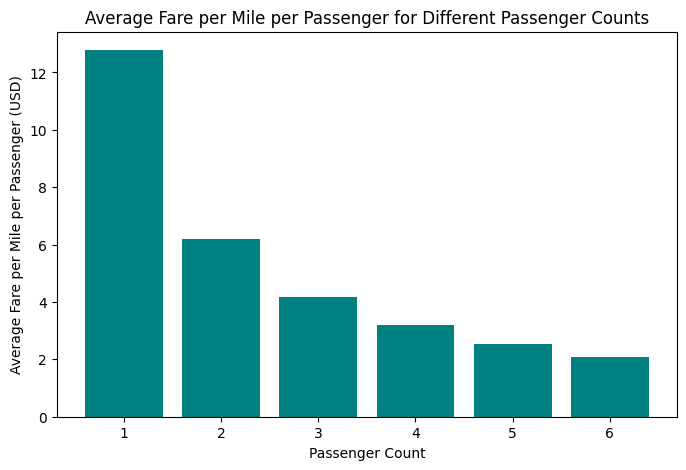

In [ ]:
# Analyse the fare per mile per passenger for different passenger counts
import matplotlib.pyplot as plt

# Filter out trips with zero or invalid distances and passenger counts
trips_filtered = df_filtered[(df_filtered['trip_distance'] > 0) & (df_filtered['passenger_count'] > 0)].copy()

# Calculate fare per mile
trips_filtered['fare_per_mile'] = trips_filtered['total_amount'] / trips_filtered['trip_distance']

# Calculate fare per mile per passenger
trips_filtered['fare_per_mile_per_passenger'] = trips_filtered['fare_per_mile'] / trips_filtered['passenger_count']

# Group by passenger count and calculate average fare per mile per passenger
avg_fare_per_mile_per_passenger = trips_filtered.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().reset_index()

# Rename columns for clarity
avg_fare_per_mile_per_passenger.columns = ['Passenger Count', 'Avg Fare per Mile per Passenger (USD)']

# Print the result
print(avg_fare_per_mile_per_passenger)

# Plotting
plt.figure(figsize=(8,5))
plt.bar(
    avg_fare_per_mile_per_passenger['Passenger Count'],
    avg_fare_per_mile_per_passenger['Avg Fare per Mile per Passenger (USD)'],
    color='teal'
)
plt.xlabel('Passenger Count')
plt.ylabel('Average Fare per Mile per Passenger (USD)')
plt.title('Average Fare per Mile per Passenger for Different Passenger Counts')
plt.xticks(avg_fare_per_mile_per_passenger['Passenger Count'])
plt.show()



**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

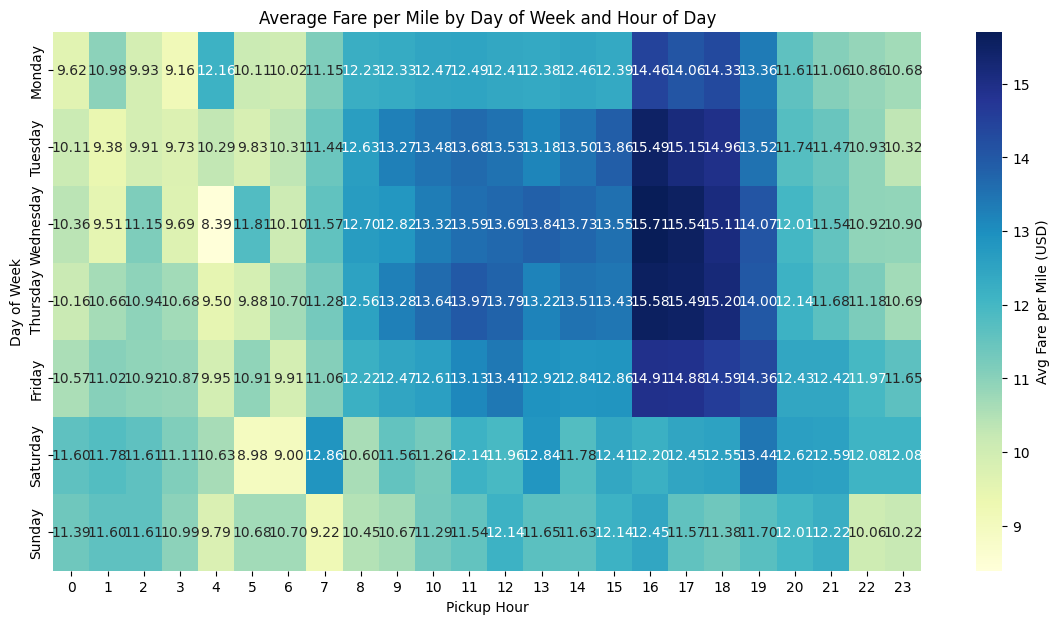

In [ ]:
# Compare the average fare per mile for different days and for different times of the day
# Filter trips with valid distance
trips_filtered = df_filtered[df_filtered['trip_distance'] > 0].copy()

# Calculate fare per mile for each trip
trips_filtered['fare_per_mile'] = trips_filtered['total_amount'] / trips_filtered['trip_distance']

# Group by pickup_day and pickup_hour, calculate average fare per mile
fare_day_hour = trips_filtered.groupby(['pickup_day', 'pickup_hour'])['fare_per_mile'].mean().reset_index()

# To ensure days are ordered correctly, define a categorical type for pickup_day
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fare_day_hour['pickup_day'] = pd.Categorical(fare_day_hour['pickup_day'], categories=day_order, ordered=True)

# Sort by day and hour for plotting
fare_day_hour = fare_day_hour.sort_values(['pickup_day', 'pickup_hour'])

# Plot heatmap: days vs hours, color = avg fare per mile
plt.figure(figsize=(14, 7))
pivot_table = fare_day_hour.pivot(index='pickup_day', columns='pickup_hour', values='fare_per_mile')
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".2f", cbar_kws={'label': 'Avg Fare per Mile (USD)'})
plt.title('Average Fare per Mile by Day of Week and Hour of Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Day of Week')
plt.show()


**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

   VendorID  Avg Fare per Mile (USD)
0         1                13.013057
1         2                12.598855


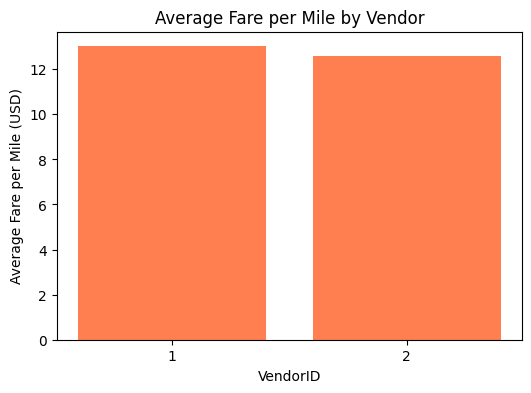

In [ ]:
# Compare fare per mile for different vendors

import matplotlib.pyplot as plt

# Filter trips with valid distance
trips_filtered = df_filtered[df_filtered['trip_distance'] > 0].copy()

# Calculate fare per mile for each trip
trips_filtered['fare_per_mile'] = trips_filtered['total_amount'] / trips_filtered['trip_distance']

# Group by VendorID and calculate average fare per mile
fare_by_vendor = trips_filtered.groupby('VendorID')['fare_per_mile'].mean().reset_index()

# Rename columns for clarity
fare_by_vendor.columns = ['VendorID', 'Avg Fare per Mile (USD)']

print(fare_by_vendor)

# Plotting
plt.figure(figsize=(6,4))
plt.bar(fare_by_vendor['VendorID'].astype(str), fare_by_vendor['Avg Fare per Mile (USD)'], color='coral')
plt.xlabel('VendorID')
plt.ylabel('Average Fare per Mile (USD)')
plt.title('Average Fare per Mile by Vendor')
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


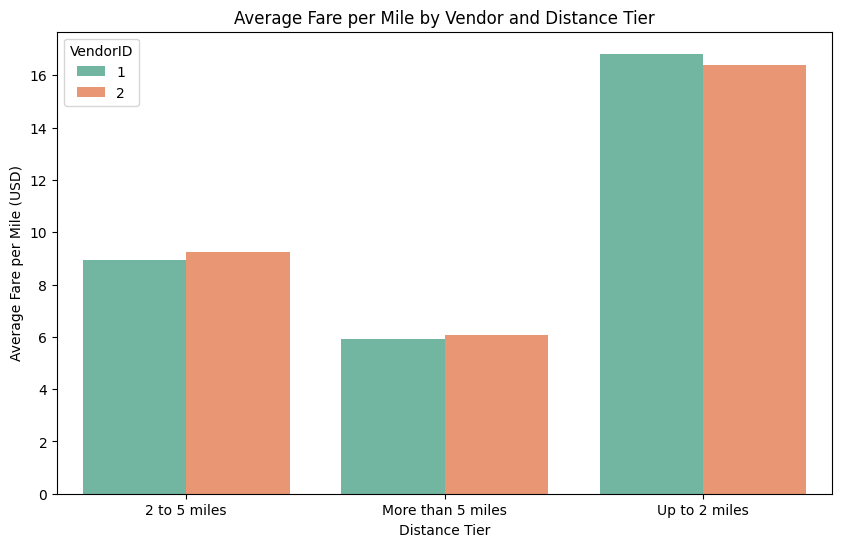

In [ ]:
# Defining distance tiers
# Filter trips with valid distance and fare
trips_filtered = df_filtered[(df_filtered['trip_distance'] > 0) & (df_filtered['total_amount'] > 0)].copy()

# Calculate fare per mile
trips_filtered['fare_per_mile'] = trips_filtered['total_amount'] / trips_filtered['trip_distance']

# Define distance tiers
def distance_tier(distance):
    if distance <= 2:
        return 'Up to 2 miles'
    elif distance <= 5:
        return '2 to 5 miles'
    else:
        return 'More than 5 miles'

trips_filtered['distance_tier'] = trips_filtered['trip_distance'].apply(distance_tier)

# Group by VendorID and distance_tier, calculate avg fare per mile
fare_tier_vendor = trips_filtered.groupby(['VendorID', 'distance_tier'])['fare_per_mile'].mean().reset_index()

# Plotting: use seaborn catplot for easier grouped bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=fare_tier_vendor, x='distance_tier', y='fare_per_mile', hue='VendorID', palette='Set2')
plt.xlabel('Distance Tier')
plt.ylabel('Average Fare per Mile (USD)')
plt.title('Average Fare per Mile by Vendor and Distance Tier')
plt.legend(title='VendorID')
plt.show()


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

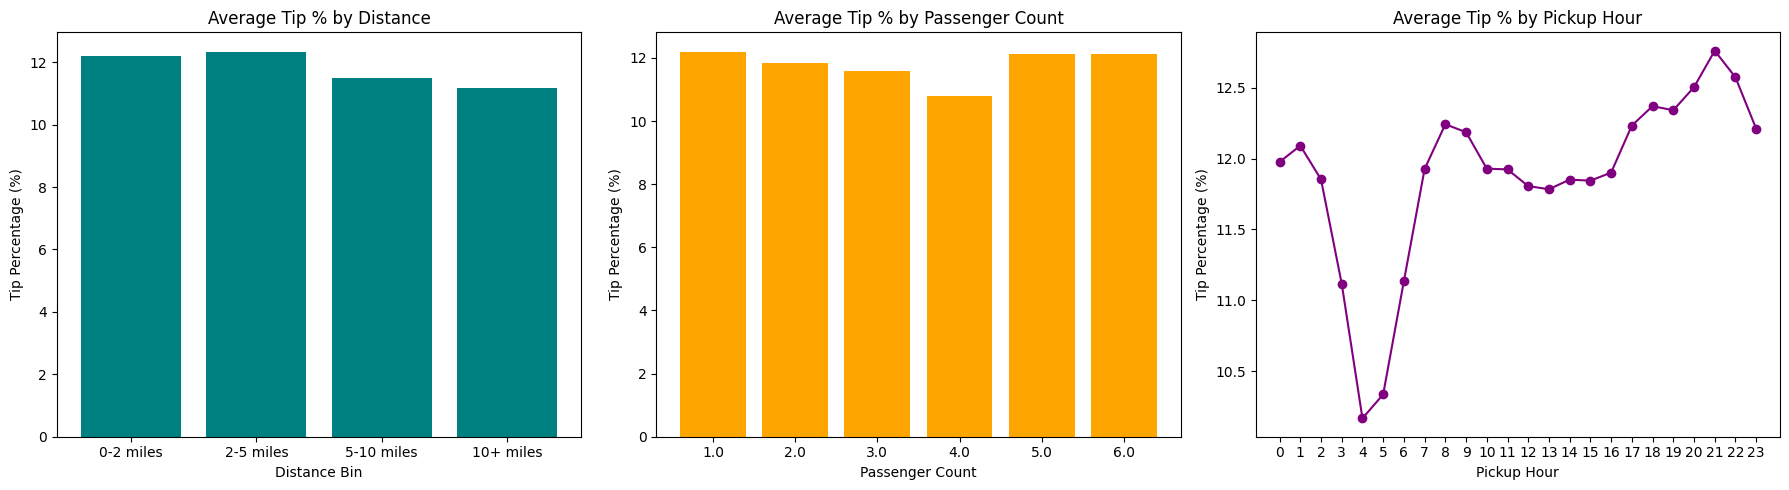

In [ ]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

# Filter valid trips for tip analysis
trips_filtered = df_filtered[(df_filtered['total_amount'] > 0) & (df_filtered['tip_amount'] >= 0)].copy()

# Calculate tip percentage
trips_filtered['tip_percentage'] = (trips_filtered['tip_amount'] / trips_filtered['total_amount']) * 100

# Define distance bins and labels
distance_bins = [0, 2, 5, 10, trips_filtered['trip_distance'].max()]
distance_labels = ['0-2 miles', '2-5 miles', '5-10 miles', '10+ miles']

# Assign distance bins
trips_filtered['distance_bin'] = pd.cut(trips_filtered['trip_distance'], bins=distance_bins, labels=distance_labels, right=False)

# Group by distance bins
tip_by_distance = trips_filtered.groupby('distance_bin')['tip_percentage'].mean().reset_index()

# Group by passenger count
tip_by_passenger = trips_filtered.groupby('passenger_count')['tip_percentage'].mean().reset_index()

# Group by pickup hour
tip_by_hour = trips_filtered.groupby('pickup_hour')['tip_percentage'].mean().reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18,5))

# Tip % by distance bins
axs[0].bar(tip_by_distance['distance_bin'].astype(str), tip_by_distance['tip_percentage'], color='teal')
axs[0].set_title('Average Tip % by Distance')
axs[0].set_xlabel('Distance Bin')
axs[0].set_ylabel('Tip Percentage (%)')

# Tip % by passenger count
axs[1].bar(tip_by_passenger['passenger_count'].astype(str), tip_by_passenger['tip_percentage'], color='orange')
axs[1].set_title('Average Tip % by Passenger Count')
axs[1].set_xlabel('Passenger Count')
axs[1].set_ylabel('Tip Percentage (%)')

# Tip % by pickup hour
axs[2].plot(tip_by_hour['pickup_hour'], tip_by_hour['tip_percentage'], marker='o', color='purple')
axs[2].set_title('Average Tip % by Pickup Hour')
axs[2].set_xlabel('Pickup Hour')
axs[2].set_ylabel('Tip Percentage (%)')
axs[2].set_xticks(range(0,24))

plt.tight_layout()
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

Average stats for trips with low and high tip percentages:
                 Low Tip (<10%)  High Tip (>25%)
trip_distance          3.644883         2.318570
total_amount          25.813560        29.775339
passenger_count        1.403729         1.391881
trip_duration         18.166568        14.879505


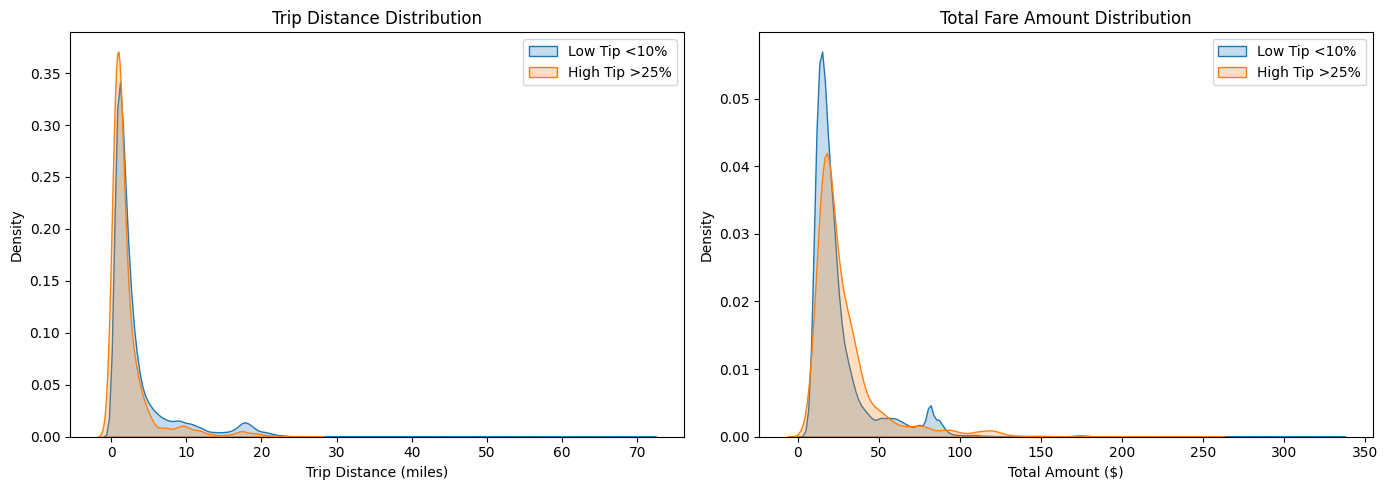

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
# Define the two groups
low_tip = trips_filtered[trips_filtered['tip_percentage'] < 10]
high_tip = trips_filtered[trips_filtered['tip_percentage'] > 25]

# Summary stats for both groups
summary_stats = pd.DataFrame({
    'Low Tip (<10%)': low_tip[['trip_distance', 'total_amount', 'passenger_count', 'trip_duration']].mean(),
    'High Tip (>25%)': high_tip[['trip_distance', 'total_amount', 'passenger_count', 'trip_duration']].mean()
})

print("Average stats for trips with low and high tip percentages:")
print(summary_stats)

# Plot distribution comparison for trip distance and fare amount
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(low_tip['trip_distance'], label='Low Tip <10%', ax=axs[0], fill=True)
sns.kdeplot(high_tip['trip_distance'], label='High Tip >25%', ax=axs[0], fill=True)
axs[0].set_title('Trip Distance Distribution')
axs[0].set_xlabel('Trip Distance (miles)')
axs[0].legend()

sns.kdeplot(low_tip['total_amount'], label='Low Tip <10%', ax=axs[1], fill=True)
sns.kdeplot(high_tip['total_amount'], label='High Tip >25%', ax=axs[1], fill=True)
axs[1].set_title('Total Fare Amount Distribution')
axs[1].set_xlabel('Total Amount ($)')
axs[1].legend()

plt.tight_layout()
plt.show()


**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

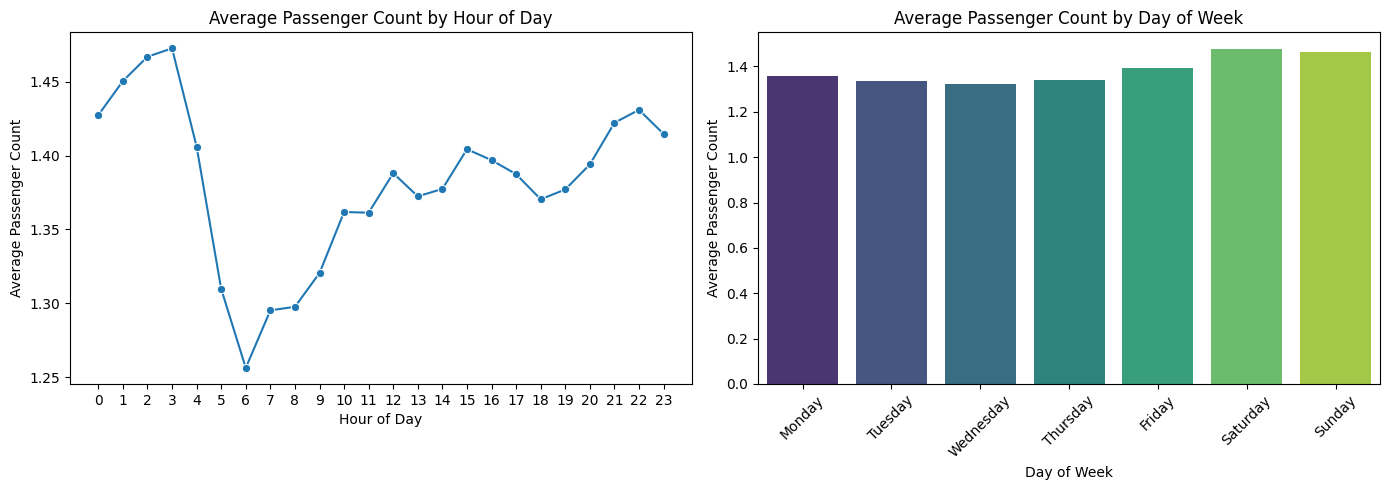

In [ ]:
# See how passenger count varies across hours and days
# Calculate average passenger count by hour
passenger_by_hour = df_filtered.groupby('pickup_hour')['passenger_count'].mean().reset_index()

# Calculate average passenger count by day of the week
# If 'pickup_day' is categorical, convert to ordered categorical for correct plotting
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_filtered['pickup_day'] = pd.Categorical(df_filtered['pickup_day'], categories=days_order, ordered=True)

passenger_by_day = df_filtered.groupby('pickup_day')['passenger_count'].mean().reset_index()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Passenger count vs Hour
sns.lineplot(data=passenger_by_hour, x='pickup_hour', y='passenger_count', marker='o', ax=axs[0])
axs[0].set_title('Average Passenger Count by Hour of Day')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Average Passenger Count')
axs[0].set_xticks(range(0, 24))

# Passenger count vs Day of Week
sns.barplot(data=passenger_by_day, x='pickup_day', y='passenger_count', palette='viridis', ax=axs[1])
axs[1].set_title('Average Passenger Count by Day of Week')
axs[1].set_xlabel('Day of Week')
axs[1].set_ylabel('Average Passenger Count')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

Top 10 zones by average passenger count:
                        zone  avg_passenger_count
177      Ocean Parkway South             3.142857
179               Ozone Park             2.058824
33        Brooklyn Navy Yard             1.866667
16                   Bedford             1.800000
11              Battery Park             1.788060
132               Kensington             1.769231
7               Astoria Park             1.750000
5    Arrochar/Fort Wadsworth             1.750000
159           Middle Village             1.708333
182               Pelham Bay             1.666667


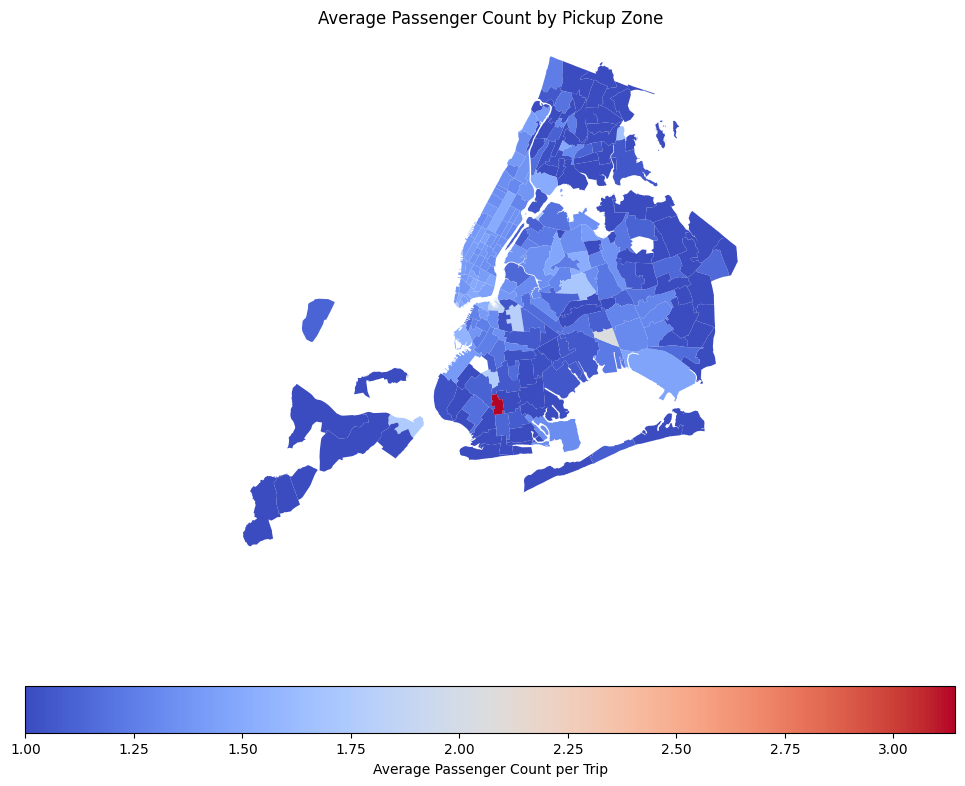

In [ ]:
# How does passenger count vary across zones
# Group trips by pickup location and calculate average passenger count
avg_passenger_by_zone = df_filtered.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_passenger_by_zone.rename(columns={'PULocationID': 'LocationID', 'passenger_count': 'avg_passenger_count'}, inplace=True)

# Merge with zones GeoDataFrame on LocationID
zones_with_passenger = zones.merge(avg_passenger_by_zone, on='LocationID', how='left')

# Display top 10 zones by average passenger count
top_zones = zones_with_passenger[['zone', 'avg_passenger_count']].sort_values(by='avg_passenger_count', ascending=False).head(10)
print("Top 10 zones by average passenger count:")
print(top_zones)

# Plot choropleth map of average passenger count per zone
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
zones_with_passenger.plot(column='avg_passenger_count',
                         ax=ax,
                         legend=True,
                         cmap='coolwarm',
                         legend_kwds={'label': "Average Passenger Count per Trip", 'orientation': "horizontal"})
ax.set_title('Average Passenger Count by Pickup Zone')
ax.axis('off')
plt.show()



In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
# Calculate average passenger count per pickup location

# Step 1: Calculate trip counts per pickup location
trip_counts = df_filtered.groupby('PULocationID').size().reset_index(name='trip_count')
trip_counts.rename(columns={'PULocationID': 'LocationID'}, inplace=True)

# Step 2: Merge trip counts with zones GeoDataFrame
zones_with_trips = zones.merge(trip_counts, on='LocationID', how='left')

# Step 3: Calculate average passenger count per pickup location
avg_passenger = df_filtered.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_passenger.rename(columns={'PULocationID': 'LocationID', 'passenger_count': 'avg_passenger_count'}, inplace=True)

# Step 4: Merge average passenger count into zones_with_trips
zones_with_trips = zones_with_trips.merge(avg_passenger, on='LocationID', how='left')

# Now check the data
zones_with_trips[['zone', 'trip_count', 'avg_passenger_count']].head()


zone  trip_count  avg_passenger_count
0           Newark Airport         8.0             1.125000
1              Jamaica Bay         NaN                  NaN
2  Allerton/Pelham Gardens        15.0             1.000000
3            Alphabet City       913.0             1.476451
4            Arden Heights         5.0             1.000000

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

improvement_surcharge: Applied in 988467 trips (100.00% of total trips)

Top 5 zones with highest frequency of improvement_surcharge applied:
   PULocationID  improvement_surcharge_freq
0             1                         1.0
1             3                         1.0
2             4                         1.0
3             5                         1.0
4             6                         1.0


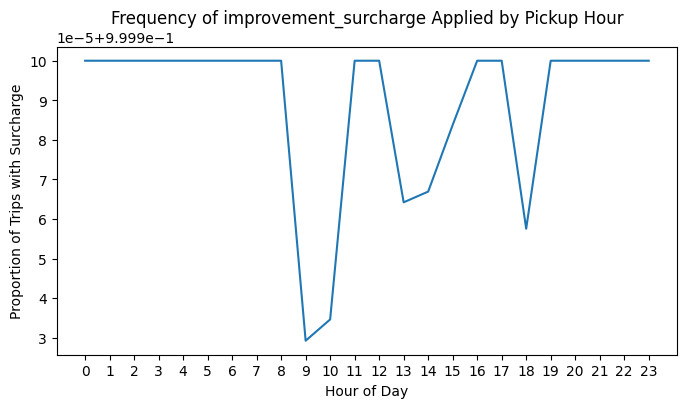

congestion_surcharge: Applied in 920394 trips (93.11% of total trips)

Top 5 zones with highest frequency of congestion_surcharge applied:
     PULocationID  congestion_surcharge_freq
6               8                   1.000000
43             46                   1.000000
55             59                   1.000000
106           120                   1.000000
101           114                   0.998314


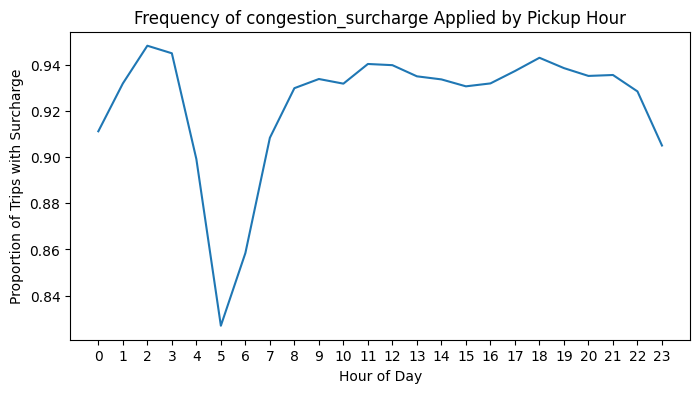

airport_fee: Applied in 85237 trips (8.62% of total trips)

Top 5 zones with highest frequency of airport_fee applied:
     PULocationID  airport_fee_freq
124           138          0.982837
118           132          0.953834
66             70          0.496180
63             67          0.230769
8              10          0.206557


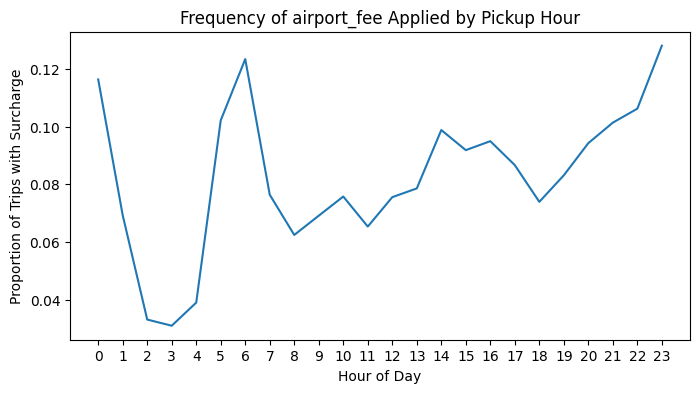

In [ ]:
# How often is each surcharge applied?

surcharge_cols = ['improvement_surcharge', 'congestion_surcharge', 'airport_fee']

total_trips = len(df_filtered)

for col in surcharge_cols:
    # Calculate overall frequency of surcharge application
    applied_count = (df_filtered[col] > 0).sum()
    print(f"{col}: Applied in {applied_count} trips ({applied_count/total_trips:.2%} of total trips)")

    # Create a boolean column for surcharge applied
    df_filtered[f'{col}_applied'] = df_filtered[col] > 0

    # Frequency of surcharge by pickup zone
    surcharge_by_zone = df_filtered.groupby('PULocationID')[f'{col}_applied'].mean().reset_index()
    surcharge_by_zone.rename(columns={f'{col}_applied': f'{col}_freq'}, inplace=True)
    print(f"\nTop 5 zones with highest frequency of {col} applied:")
    print(surcharge_by_zone.sort_values(by=f'{col}_freq', ascending=False).head())

    # Frequency of surcharge by pickup hour
    surcharge_by_hour = df_filtered.groupby('pickup_hour')[f'{col}_applied'].mean().reset_index()

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=surcharge_by_hour, x='pickup_hour', y=f'{col}_applied')
    plt.title(f'Frequency of {col} Applied by Pickup Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Proportion of Trips with Surcharge')
    plt.xticks(range(0, 24))
    plt.show()


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [ ]:
Dynamic Dispatching: Allocate more taxis to high-demand zones and peak hours; differentiate strategies for day and night.

Route Optimization: Avoid congested routes using speed and congestion data; reroute taxis to reduce delays.

Reduce Idle Time: Match dropoff and pickup zones to minimize empty trips and idle time.

Pricing Adjustments: Use tiered fares and incentives to balance demand, encourage off-peak travel, and increase driver earnings.

Passenger Load Management: Promote shared rides and assign vehicles based on passenger count to improve efficiency.

Real-time Integration: Incorporate live traffic, weather, and driver feedback for smarter dispatch decisions.

Visual Mapping: Use maps to identify hotspots and adjust operations near airports and congested areas.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [ ]:
Focus cabs in high-demand zones during peak hours (e.g., business areas in mornings, nightlife zones at night).

Adjust cab distribution by time of day, shifting between residential, commercial, and entertainment areas.

Differentiate weekend vs. weekday placements to match changing demand patterns.

Consider seasonal and monthly trends to position cabs near events or tourist spots.

Avoid oversupplying congested zones; use nearby less-congested areas instead.

Leverage historical dropoff-to-pickup flows to reduce idle time.

Update positioning dynamically with real-time demand data.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [ ]:
Set tiered fares based on trip distances (short, medium, long).

Apply dynamic pricing with surge rates during peak times and zones; offer discounts off-peak.

Encourage larger groups with passenger-based fare incentives.

Balance base fares and service quality to optimize tips.

Benchmark competitor fares to stay competitive in sensitive zones.

Transparently apply surcharges like congestion and airport fees.

Continuously monitor and adjust pricing based on revenue and customer feedback.